# Data Analysis - Semantic vs. Syntactic dependecies

In [676]:
import sys, os, json
from collections import defaultdict, Counter
from itertools import product, combinations, permutations
from importlib import reload
from glob import glob
from IPython.display import HTML, display
import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Any, Dict, Tuple, Callable, Iterable, Union, Set
Numeric = Union[int, float]
from graph import Graph, Node     # mtool graphs
import networkx as nx, numpy as np, pandas as pd
from networkx import NetworkXNoPath

# a hack for functional-like posfix list functions (map, filter, count, size)
import gc
postfix_map = lambda l,f: list(map(f,l))
postfix_filter = lambda l,f: list(filter(f,l))
postfix_count = lambda l,f: len(list(filter(f,l)))
gc.get_referents(list.__dict__)[0]['map'] = postfix_map
gc.get_referents(list.__dict__)[0]['filter'] = postfix_filter
gc.get_referents(list.__dict__)[0]['count'] = postfix_count
gc.get_referents(list.__dict__)[0]['size'] = lambda l:len(l)

# root of project in nlp-architext repo
libert_dir = "/data/home/ayalklei/nlp-architect/nlp_architect/models/libert"
analysis_dir = f"{libert_dir}/analysis"

# useful "meta" data - number of sentence per domain 
# (can be computed by #-lines in raw_sentences.txt files - `wc $liber_dir/analysis/raw_sentences/*.txt`)
num_sents = {"device": 3834, "restaurants": 5842, "laptops": 3846}
domains = ["restaurants", "laptops", "device"]
datasets = list(permutations(domains, 2))

ud_enhancement_formalisms = ["eud", "eud_pp", "bart", "eud_pp_bart"]
# usefull general utils
def display_table(table):
    display(HTML(tabulate.tabulate(table, tablefmt='html')))
def display_1d_dict(dic):
    keys, values = zip(*dic.items())
    display_table([keys, values])
def display_ndict(nested_dict: Dict[str, Dict[str, Any]], 
                  with_mean=True, 
                  pprint: Callable = None,
                  precision: int = 4):
    """ Display two-level nested dict as a pretty table. """
    if not pprint:
        def pprint_f(x):
            if isinstance(x, float):
                return float(f"{x:.{precision}f}")
            else:
                return x
        pprint = pprint_f
    row_labels = list(nested_dict.keys())
    column_labels = list(list(nested_dict.values())[0].keys())
    as_tabular = [["-"] + column_labels] + \
                 [[row] + [pprint(nested_dict[row][col]) for col in column_labels]
                  for row in row_labels]
    if with_mean:
        as_tabular[0] += ["mean"]
        for i in range(1, len(as_tabular)):
            mean = np.mean(as_tabular[i][1:])
            as_tabular[i] += [pprint(mean)]
    display_table(as_tabular)

def display_absa_graph(graph: Graph, method="displacy"):
    # visualize
    print(f"Sentence: {graph.input}")
    if method == "dot":
        # visalize using dot
        dot_fn = "dot_example.dot"
        graph.dot(open(dot_fn, "w"))    # write dot file
        # see dot in jupyter
        def view_dot(fn):
            from graphviz import Source
            return Source.from_file(fn)
        return view_dot(dot_fn)
    elif method=="tikz":
        # visalize using tikz
        tikz_fn = "tikz_example.tex"
        graph.tikz(open(tikz_fn, "w"))    # write tikz latex file
        # I can't show it in notebook meantime since %load_ext tikzmagic not working
        return None
    else:
        print("opinions: ", graph.opinion_spans, 
              [' '.join(graph.input.split(" ")[i] 
                        for i in range(*span))
                        for span in graph.opinion_spans])
        print("aspects: ", graph.aspect_spans,
              [' '.join(graph.input.split(" ")[i] 
                        for i in range(*span))
                        for span in graph.aspect_spans])
        graph.displacy(jupyter=True, options={"compact":True, "distance":100})
            
def plot_hist_with_long_labels(array, bins=None, title=""):
    """ Display hostogram with rotated x-labels """
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.hist(array, bins = bins or len(array), color = 'red', edgecolor = 'black',)
    for tick in ax.get_xticklabels():
        tick.set_rotation(270)
    ax.set_title(title)

def plot_bar_with_long_labels(labels, values, title="", save_as=None):
    """ Display histogram with rotated x-labels """
    import matplotlib.pyplot as plt
    indexes = np.arange(len(labels))
    fig, ax = plt.subplots()
    ax.bar(indexes, values, color = 'blue', edgecolor = 'black')
    for tick in ax.get_xticklabels():
        tick.set_rotation(270)
    plt.xticks(indexes, labels)
    ax.set_title(title)
    if save_as:
        plt.savefig(save_as)

def plot_counter_with_long_labels(c: Counter):
    plot_bar_with_long_labels(*zip(*c.items()))
    
def report_overlap(**kwargs):
    assert len(kwargs)==2
    (nm1, s1), (nm2, s2) = tuple(kwargs.items())
    s1, s2 = set(s1), set(s2)
    print(f"|{nm1}|={len(s1)}, |{nm2}|={len(s2)};   Union: {len(s1|s2)}  Intersection: {len(s1&s2)} ")
    print(f"|{nm1}-{nm2}|={len(s1-s2)}, |{nm2}-{nm1}|={len(s2-s1)};   ")

In [481]:
# general DS utils (lists, sets, dicts, counters)
def counter_as_accumulative(counter: Counter) -> Counter:
    """ Return the accumulative distribution of the `counter` distribution.
        `counter` keys should be numbers. """
    sorted_keys = list(sorted(counter.keys()))
    accum = 0
    out = {}
    for k in sorted_keys:
        accum += counter[k]
        out[k] = accum
    return out

def counter_as_relative(distribution: Dict):
    # get a list\dict of numbers (a distribution), return the relative distribution (element/sum)
    sm = float(sum(distribution.values()))
    return {k: v / sm for k, v in distribution.items()}

def is_iterable(e):
    return '__iter__' in dir(e)

def flatten(lst, recursively=False):
    """ Flatten a list.
    if recursively=True, flattens all levels of nesting, until reaching non-iterable items
    (strings are considered non-iterable to that matter.)
    :returns a flatten list (a non-nested list)
    """
    if not is_iterable(lst):
        return lst
    out = []
    for element in lst:
        if is_iterable(element):
            if recursively:
                out.extend(flatten(element))
            else:
                out.extend(element)
        else:
            out.append(element)
    return out

def IOU(set1, set2):
    set1 = set(set1)
    set2 = set(set2)
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union

def agg(d: Dict[Any, List[Any]]) -> List[Any]:
    " Aggreate values of 1-level dict holding list, e.g. all_graphs['ud'] := {domain: [graph1, ...]} "
    return flatten(d.values())
def agg2l(d: Dict[Any, Any]) -> List[Any]:
    " Aggreate values of 2-level nested dict. "
    return [d[k1][k2] for k1 in d for k2 in d[k1]]
def agg2l_l(d: Dict[Any, List[Any]]) -> List[Any]:
    " Aggreate values of 2-level nested dict holding list, e.g. all_graphs := {frmlsm: {domain: [graph1, ...]}} "
    return flatten(agg2l(d))

In [7]:
# utils for loading and visualizing dependency graphs (both syntactic and semantic) 
def load_parsed_graph(formalism="dm", domain="restaurants", graph_id = 1) -> Graph:
    # load a parsed graph
    if formalism is "spacy":
        parsed_graphs_dir=f"{libert_dir}/analysis/spacy-syndep-parses"
        parsed_fn=f"{parsed_graphs_dir}/{domain}-syndep.mrp"
    elif formalism is "ud":
        parsed_graphs_dir=f"{libert_dir}/analysis/udpipe-syndep-parses"
        parsed_fn=f"{parsed_graphs_dir}/{domain}-syndep.mrp"
    elif formalism in ud_enhancement_formalisms:
        parsed_graphs_dir=f"{libert_dir}/analysis/ud-enhancements/{formalism}"
        parsed_fn=f"{parsed_graphs_dir}/{domain}-syndep.mrp"
    elif formalism in ["dm", "psd"]:    
        parsed_graphs_dir=f"{libert_dir}/analysis/HIT-SCIR-parses"
        parsed_fn=f"{parsed_graphs_dir}/{formalism}-{domain}-output.mrp"
    else:
        raise ValueError(f"formalism {formalism} is not among supprted formalisms - clir (spacy), ud, dm, psd")
    with open(parsed_fn) as fin:
        lines = list(fin.readlines())
    g = Graph.decode(json.loads(lines[graph_id]))
    # fix nodes in parsed_graph to include all tokens in input sentence
    g._full_sentence_recovery() 
    return g


# running example
g = load_parsed_graph("spacy")
print([n.label for n in g.nodes], len(g.nodes))


['To', 'be', 'completely', 'fair', ',', 'the', 'only', 'redeeming', 'factor', 'was', 'the', 'food', ',', 'which', 'was', 'above', 'average', ',', 'but', 'could', "n't", 'make', 'up', 'for', 'all', 'the', 'other', 'deficiencies', 'of', 'Teodora', '.'] 31


## Loading ABSA information into graphs
Mark nodes in the graph with 'opinion' and 'aspect' boolean attributes  

In [8]:
# first, read ABSA data from "conll" BIO-tagged files into a intermediate format.
# our format will be per sentence - {"sentence_id":..., "tokens": [...], "token_tags": [...], 
#                                       "aspect_spans": [(from_id, to_id), ...],
#                                       "opinion_spans": [(from_id, to_id), ...]}
absa_data_dir = f"{libert_dir}/data/conll/domains_all"
absa_data = {}
formalisms = ["spacy", "ud", "dm", "psd"] + ud_enhancement_formalisms
for domain in domains:
    absa_bio_fn = f"{absa_data_dir}/{domain}.txt"
    with open(absa_bio_fn) as fin:
        # read blocks, and in empty lines (=block delimiter) - consolidate block (=sentence) info
        block_tuples = []   # a tuple correspond to a line; 
                            # in these conll-bio ABSA files, it is a (token, bio_tag) pair
        bio_spans, cur_span_info = [], None
        data = []
        running_sentence_id = 0
        token_id = 0
        for line in fin:
            line = line.strip()
            if line != "":
                block_tuples.append(line.split())
                # on the same pass, collect BIO spans info
                _, bio_tag = line.split()
                if (bio_tag == "O" or bio_tag.startswith("B")) and cur_span_info: 
                    # finalize previous span
                    cur_span_info["to"] = token_id  # span is exclusive
                    bio_spans.append(cur_span_info)
                    cur_span_info = None
                if bio_tag.startswith("B"): # start new span 
                    # start new span 
                    label = bio_tag.split("-")[1]
                    cur_span_info = {"from": token_id, "label": label}
                token_id += 1
            else:   # line seperator, consolidate block information
                tokens, bio_tags = zip(*block_tuples)
                # ABSA-specific logic:
                # split bio_spans into aspect spans and opinion spans 
                apsect_spans = [(s["from"], s["to"]) for s in bio_spans if s["label"]=="ASP"]
                opinion_spans = [(s["from"], s["to"]) for s in bio_spans if s["label"]=="OP"]

                sentence_data = {"sentence_id": f"{running_sentence_id:04}",
                                 "tokens": list(tokens),
                                 "token_tags": bio_tags,    # auxilary info
                                 "apsect_spans": apsect_spans,
                                 "opinion_spans": opinion_spans}
                data.append(sentence_data) 
                # initialize for next block   
                running_sentence_id += 1
                block_tuples = [] 
                token_id = 0
                bio_spans, cur_span_info = [], None
    absa_data[domain] = data

In [9]:
# now with any loaded graph, we can augment ABSA information into graph
def load_absa_graph(formalism="dm", domain="laptops", graph_id = 3240):
    g = load_parsed_graph(formalism=formalism, domain=domain, graph_id=graph_id)
    sent_absa = absa_data[domain][graph_id]
    # verify correspondense
    assert g.input.split() == sent_absa["tokens"], \
        f"mismatch between parsed graph and absa-data: '{g.input.split()}' vs. '{sent_absa['tokens']}'"
    # augment ABSA info into graphs:
    #  - in graph level (`aspect_spans` and `opinion_spans` graph properties)
            # `first_node` requisite: fixing node ids in "aspect/opinion terms" so that they will correspond 
            # to their index in g.nodes list. It is mainly for 1-indexed graphs like
            # those deserialized from CoNLL-U files (where first token's id is 1 and not 0).
    first_node = min(n.id for n in g.nodes)
    g.aspect_spans = [(b+first_node,e+first_node) for b,e in sent_absa["apsect_spans"]]
    g.opinion_spans = [(b+first_node,e+first_node) for b,e in sent_absa["opinion_spans"]]
    #  - in node level (`aspect_term` and `opinion_term` node properties)
    for n in g.nodes:
        n.aspect_term = False
        n.opinion_term = False
    for span in g.aspect_spans:
        for i in range(*span):
            g.find_node(i).aspect_term = True
    for span in g.opinion_spans:
        for i in range(*span):
            g.find_node(i).opinion_term = True
    return g

# Select running example 
formalism="spacy"; domain="device"; graph_id=1
g = load_parsed_graph(formalism=formalism, domain=domain, graph_id=graph_id)
g2 = load_absa_graph(formalism=formalism, domain=domain, graph_id=graph_id)
# display_absa_graph(g2)
# absa_data["laptops"][3034]
# [n.label for n in g.nodes]
formalisms


['spacy', 'ud', 'dm', 'psd', 'eud', 'eud_pp', 'bart', 'eud_pp_bart']

In [9]:
# inspect some properties of example graph
print('  '.join([f"{i}:{tok}" for i,tok in enumerate(g2.input.split())]))
print("aspects:", g2.aspect_spans)
print("opinions:", g2.opinion_spans)

0:there  1:is  2:much  3:which  4:has  5:been  6:said  7:in  8:other  9:reviews  10:about  11:the  12:features  13:of  14:this  15:phone  16:,  17:it  18:is  19:a  20:great  21:phone  22:,  23:mine  24:worked  25:without  26:any  27:problems  28:right  29:out  30:of  31:the  32:box  33:.
aspects: [(16, 17), (22, 23)]
opinions: [(21, 22)]


## Collect & Filter indicative graphs
Filter sentences with single OT & single AT. Since we don't have a AT<->OT mapping in the annotations, we should limit the analysis of AT--OT paths to cases where we are certain they are corresponding.   

In [10]:
# collect all graphs (by formalism, by domain) - NOTE: takes several minutes in first run, afterwards loading from file
from collections import defaultdict
import pickle
all_graphs_fn = "all_absa_graphs.pickle"
try:
    all_graphs = pickle.load(open(all_graphs_fn, "rb"))
except FileNotFoundError:
    all_graphs = defaultdict(dict)  # will be: {<formalism>: {<domain>: [sent-0-graph, ...], ...}, ...}
    for formalism in formalisms:
        for domain in domains:
            graphs = [load_absa_graph(formalism, domain, i) for i in range(num_sents[domain])]
            all_graphs[formalism][domain] = graphs
    pickle.dump(all_graphs, open(all_graphs_fn, "wb"))

In [19]:
def count_graphs(graphs: Dict[str, Dict[str, List[Graph]]]) -> int:
    return  sum([1
                 for formalism_dict in list(graphs.values())[:1]
                 for domain_list in formalism_dict.values()
                 for g in domain_list])
print(f"collected {count_graphs(all_graphs)} graphs for {len(formalisms)} formalisms")

collected 13522 graphs for 5 formalisms


In [20]:
# filter indicative graphs 
def is_indicative_graph(g: Graph) -> bool:
    """ return true iff sentence have a single Aspect-Term (AT) and a single Opinion-Term (OT). """
    return len(g.aspect_spans)==1 and len(g.opinion_spans)==1

indicative_sentences_ids = {domain: [i
                                     for i in range(num_sents[domain]) 
                                     if is_indicative_graph(all_graphs["ud"][domain][i])]
                            for domain in domains}
all_indicative_graphs = {formalism: 
                             {domain: 
                                  [all_graphs[formalism][domain][i]
                                   for i in range(num_sents[domain])
                                   if i in indicative_sentences_ids[domain]]
                              for domain in domains}
                         for formalism in formalisms}


In [21]:
print(f"collected {count_graphs(all_indicative_graphs)} graphs for {len(formalisms)} formalisms")

collected 2451 graphs for 5 formalisms


## Leveraging NetworkX classes for data analysis
We will convert mtool's `Graph`s to `nx.DiGraph` objects. 
Then, we can use nx to search for path and to convert the graph to an undirected graph. 


In [22]:
def take_keys(d: Dict, keys: List[Any]):
    return {k:v for k,v in d.items() if k in keys}

def to_nx(g: Graph) -> nx.DiGraph:
    graph_attr = take_keys(g.__dict__, ["flavor", "framework", "id", "input", "opinion_spans", "aspect_spans"])
    nxg = nx.DiGraph(**graph_attr)
    nxg.g = g # save original `mtool` Graph object simple as `g` property
    # for better transparency between nx.DiGraph and mtool's Graph, put graph attributes
    # as first order properties in DiGraph object
    nxg.__dict__.update(**graph_attr)
    # add nodes
    for node in g.nodes:
        attr = take_keys(node.__dict__, ['id', 'anchors', 'label', 'is_top', 'type', 'opinion_term', 'aspect_term'])
        # put g.node properties as first-order citizens in nxg.node properties
        if node.properties and node.values:
            attr.update(dict(zip(node.properties, node.values)))
        nxg.add_node(node.id, **attr)
    # add edges
    for edge in g.edges:
        attr = take_keys(edge.__dict__, ['lab', 'anchors', 'id', 'normal'])
        # put g.edge attributes as first-order citizens in nxg.edge properties
        if edge.attributes and edge.values:
            attr.update(dict(zip(edge.attributes, edge.values)))
        nxg.add_edge(edge.src, edge.tgt, **attr)
    return nxg

# running example
g2 = all_indicative_graphs["ud"]["device"][0]
nxg = to_nx(g2)
[]

[]

## Compute average **directed** path length between AT and OT

In [23]:
def filtered(array):
    filtered_array = [e for e in array if e is not None]
    return filtered_array 

def filtered_f(array, f: Callable[[Iterable[Graph],], Any]):
    filtered_array = filtered(array)
    return f(filtered_array) if filtered_array else None

    
def directed_path_length(nxg: nx.DiGraph):
    def shortest_path_length(source, target) -> Union[int, None]:
        try:
            return nx.shortest_path_length(nxg, source=source, target=target)
        except NetworkXNoPath:
            return None
        
    # Return the minimum path length between an OT token and an AT token (either AT~~>OT or OT~~>AT)
    OT2AT_path_lengths = [shortest_path_length(source_tokid, target_tokid) 
                          for source_tokid in range(*nxg.opinion_spans[0])
                          for target_tokid in range(*nxg.aspect_spans[0])]
    AT2OT_path_lengths = [shortest_path_length(source_tokid, target_tokid) 
                          for source_tokid in range(*nxg.aspect_spans[0])
                          for target_tokid in range(*nxg.opinion_spans[0])]
    return filtered_f(OT2AT_path_lengths + AT2OT_path_lengths, min)


In [24]:
# compute average directed path length per formalism per domain. 
mean_directed_path_length = defaultdict(dict)
dist_directed_path_length = defaultdict(dict) # disribution of path lengths
count_is_directed_path = defaultdict(dict)
count_indicative_graphs = defaultdict(dict)
percentage_direct_relation = defaultdict(dict) # out of all indicative graphs, %-graphs with direct relation (path-length==1)

for formalism in formalisms:
    for domain in domains:
        shortest_paths = [directed_path_length(to_nx(g)) 
                          for g in all_indicative_graphs[formalism][domain]]
        n_graphs = len(all_indicative_graphs[formalism][domain])
        count_indicative_graphs[formalism][domain] = n_graphs
        mean_directed_path_length[formalism][domain] = filtered_f(shortest_paths, np.mean)
        dist = filtered_f(shortest_paths, Counter) 
        dist_directed_path_length[formalism][domain] = dist
        count_is_directed_path[formalism][domain] = filtered_f(shortest_paths, len)
        percentage_direct_relation[formalism][domain] = 100* (dist[1] / n_graphs)

#### Results

In [25]:
# display results in tables
print("#-Graphs for analysis (single AT & single OT):")
display_ndict(count_indicative_graphs)
print("#-Graphs that have a directed path AT~~>OT or OT~~>AT:")
display_ndict(count_is_directed_path)
print("Mean of shortest path length between AT and OT (if exists):")
display_ndict(mean_directed_path_length)
print("Distribution (Counter) of shortest path lengths between AT and OT:")
display_ndict(dist_directed_path_length, with_mean=False)
print("%-graphs with direct relation (out of all graphs):")
display_ndict(percentage_direct_relation)


#-Graphs for analysis (single AT & single OT):


-,device,restaurants,laptops,mean
spacy,551,1291,609,817.0
ud,551,1291,609,817.0
dm,551,1291,609,817.0
psd,551,1291,609,817.0
eud_pp,551,1291,609,817.0


#-Graphs that have a directed path AT~~>OT or OT~~>AT:


-,device,restaurants,laptops,mean
spacy,225,563,286,358.0
ud,404,1001,461,622.0
dm,392,898,378,556.0
psd,200,558,263,340.3333
eud_pp,407,1009,467,627.6667


Mean of shortest path length between AT and OT (if exists):


-,device,restaurants,laptops,mean
spacy,1.3244,1.3552,1.472,1.3839
ud,1.1634,1.1379,1.256,1.1858
dm,1.125,1.0846,1.164,1.1245
psd,1.165,1.1882,1.2357,1.1963
eud_pp,1.1572,1.1328,1.227,1.1723


Distribution (Counter) of shortest path lengths between AT and OT:


-,device,restaurants,laptops
spacy,"Counter({1: 178, 2: 34, 3: 6, 5: 4, 4: 2, 6: 1})","Counter({1: 423, 2: 102, 3: 22, 4: 11, 5: 4, 6: 1})","Counter({1: 204, 2: 51, 3: 21, 4: 4, 6: 3, 5: 2, 8: 1})"
ud,"Counter({1: 355, 2: 33, 3: 15, 4: 1})","Counter({1: 901, 2: 70, 3: 23, 4: 6, 5: 1})","Counter({1: 375, 2: 64, 3: 14, 4: 6, 5: 2})"
dm,"Counter({1: 353, 2: 31, 3: 6, 4: 2})","Counter({1: 833, 2: 59, 3: 4, 7: 1, 4: 1})","Counter({1: 327, 2: 41, 3: 9, 4: 1})"
psd,"Counter({1: 178, 2: 13, 3: 7, 4: 2})","Counter({1: 481, 2: 56, 3: 14, 4: 7})","Counter({1: 222, 2: 28, 3: 9, 5: 2, 6: 1, 4: 1})"
eud_pp,"Counter({1: 360, 2: 31, 3: 15, 4: 1})","Counter({1: 910, 2: 72, 3: 20, 4: 6, 5: 1})","Counter({1: 389, 2: 58, 3: 14, 4: 4, 5: 2})"


%-graphs with direct relation (out of all graphs):


-,device,restaurants,laptops,mean
spacy,32.3049,32.7653,33.4975,32.8559
ud,64.4283,69.7909,61.5764,65.2652
dm,64.0653,64.5236,53.6946,60.7612
psd,32.3049,37.2579,36.4532,35.3387
eud_pp,65.3358,70.488,63.8752,66.5663


## Compute average **undirected** path length between AT and OT

In [26]:
def undirected_path_length(nxg: nx.DiGraph):
    nxug = nxg.to_undirected()
    def shortest_path_length(source, target) -> Union[int, None]:
        try:
            return nx.shortest_path_length(nxug, source=source, target=target)
        except NetworkXNoPath:
            return None
        
    # Return the minimum path length between an OT token and an AT token (AT<~~>OT)
    path_lengths = [shortest_path_length(source_tokid, target_tokid)
                    for source_tokid in range(*nxg.opinion_spans[0])
                    for target_tokid in range(*nxg.aspect_spans[0])]
    return filtered_f(path_lengths, min)

# compute average undirected path length per formalism per domain. 
mean_undirected_path_length = defaultdict(dict)
count_is_undirected_path = defaultdict(dict)
dist_undirected_path_length = defaultdict(dict) # disribution of path lengths
dist_cumm_rel_undirected_path_length = defaultdict(dict) # cummulative relative disribution of path lengths

percentage_direct_relation = defaultdict(dict) # out of all indicative graphs, %-graphs with direct relation (path-length==1)

for formalism in formalisms:
    for domain in domains:
        shortest_paths = [undirected_path_length(to_nx(g)) 
                          for g in all_indicative_graphs[formalism][domain]]
        n_graphs = len(all_indicative_graphs[formalism][domain])
        count_indicative_graphs[formalism][domain] = n_graphs
        dist = filtered_f(shortest_paths, Counter) 
        dist_undirected_path_length[formalism][domain] = dist
        dist_cumm_rel_undirected_path_length[formalism][domain] = \
            counter_as_accumulative(counter_as_relative(dist))
        count_is_undirected_path[formalism][domain] = filtered_f(shortest_paths, len)
        percentage_direct_relation[formalism][domain] = 100* (dist[1] / n_graphs)
        mean_undirected_path_length[formalism][domain] = filtered_f(shortest_paths, np.mean)


In [27]:
# display results in tables
print("#-Graphs for analysis (single AT & single OT):")
display_ndict(count_indicative_graphs)
print("#-Graphs that have an undirected path AT<~~>OT:")
display_ndict(count_is_undirected_path)
print("Mean of shortest undirected path length between AT and OT (if exists):")
display_ndict(mean_undirected_path_length)
print("Distribution (Counter) of shortest undirected path lengths between AT and OT:")
display_ndict(dist_undirected_path_length, with_mean=False)
print("Cummlative Relative Distribution (Counter) of these path lengths:")
display_ndict(dist_cumm_rel_undirected_path_length, with_mean=False)
print("%-graphs with direct (undirected) relation (out of all graphs):")
display_ndict(percentage_direct_relation)

#-Graphs for analysis (single AT & single OT):


-,device,restaurants,laptops,mean
spacy,551,1291,609,817.0
ud,551,1291,609,817.0
dm,551,1291,609,817.0
psd,551,1291,609,817.0
eud_pp,551,1291,609,817.0


#-Graphs that have an undirected path AT<~~>OT:


-,device,restaurants,laptops,mean
spacy,551,1291,609,817.0
ud,551,1291,609,817.0
dm,543,1264,592,799.6667
psd,545,1279,593,805.6667
eud_pp,551,1291,609,817.0


Mean of shortest undirected path length between AT and OT (if exists):


-,device,restaurants,laptops,mean
spacy,2.1797,2.1077,2.2808,2.1894
ud,1.5717,1.4833,1.6502,1.5684
dm,1.7145,1.697,1.9611,1.7909
psd,2.0606,1.9633,2.059,2.0276
eud_pp,1.5554,1.4632,1.6108,1.5431


Distribution (Counter) of shortest undirected path lengths between AT and OT:


-,device,restaurants,laptops
spacy,"Counter({2: 235, 1: 178, 3: 67, 4: 28, 5: 28, 6: 8, 7: 5, 8: 1, 9: 1})","Counter({2: 557, 1: 423, 3: 175, 4: 71, 5: 40, 6: 10, 7: 8, 8: 5, 10: 1, 9: 1})","Counter({2: 209, 1: 204, 3: 97, 4: 54, 5: 24, 6: 11, 7: 6, 8: 4})"
ud,"Counter({1: 355, 2: 111, 3: 59, 4: 19, 5: 6, 6: 1})","Counter({1: 901, 2: 231, 3: 112, 4: 31, 5: 11, 7: 2, 6: 2, 11: 1})","Counter({1: 375, 2: 131, 3: 58, 4: 34, 5: 8, 6: 3})"
dm,"Counter({1: 353, 2: 79, 3: 60, 4: 30, 5: 13, 7: 3, 6: 3, 8: 2})","Counter({1: 833, 2: 197, 3: 112, 4: 63, 5: 39, 6: 12, 7: 5, 9: 2, 10: 1})","Counter({1: 327, 2: 110, 3: 76, 4: 40, 5: 17, 6: 15, 7: 6, 9: 1})"
psd,"Counter({2: 232, 1: 178, 3: 81, 4: 37, 5: 13, 6: 3, 7: 1})","Counter({2: 541, 1: 481, 3: 140, 4: 75, 5: 32, 6: 6, 7: 2, 8: 1, 10: 1})","Counter({1: 222, 2: 216, 3: 91, 4: 38, 5: 17, 6: 6, 7: 3})"
eud_pp,"Counter({1: 360, 2: 108, 3: 57, 4: 21, 5: 4, 6: 1})","Counter({1: 910, 2: 234, 3: 103, 4: 29, 5: 11, 7: 2, 6: 1, 11: 1})","Counter({1: 389, 2: 120, 3: 61, 4: 29, 5: 7, 6: 3})"


Cummlative Relative Distribution (Counter) of these path lengths:


-,device,restaurants,laptops
spacy,"{1: 0.32304900181488205, 2: 0.7495462794918331, 3: 0.8711433756805808, 4: 0.9219600725952813, 5: 0.9727767695099819, 6: 0.9872958257713249, 7: 0.9963702359346643, 8: 0.9981851179673322, 9: 1.0}","{1: 0.32765298218435324, 2: 0.7591014717273432, 3: 0.8946553059643687, 4: 0.9496514329976762, 5: 0.9806351665375678, 6: 0.9883810999225406, 7: 0.994577846630519, 8: 0.9984508133230054, 9: 0.9992254066615027, 10: 1.0}","{1: 0.33497536945812806, 2: 0.6781609195402298, 3: 0.8374384236453202, 4: 0.9261083743842364, 5: 0.9655172413793103, 6: 0.9835796387520525, 7: 0.9934318555008209, 8: 0.9999999999999999}"
ud,"{1: 0.6442831215970962, 2: 0.8457350272232305, 3: 0.9528130671506352, 4: 0.9872958257713248, 5: 0.998185117967332, 6: 0.9999999999999999}","{1: 0.6979085979860573, 2: 0.876839659178931, 3: 0.9635941130906274, 4: 0.9876065065840434, 5: 0.9961270333075135, 6: 0.9976762199845081, 7: 0.9992254066615026, 11: 0.9999999999999999}","{1: 0.6157635467980296, 2: 0.8308702791461412, 3: 0.9261083743842364, 4: 0.9819376026272578, 5: 0.9950738916256158, 6: 1.0}"
dm,"{1: 0.6500920810313076, 2: 0.7955801104972375, 3: 0.9060773480662982, 4: 0.9613259668508286, 5: 0.9852670349907918, 6: 0.9907918968692448, 7: 0.9963167587476979, 8: 0.9999999999999999}","{1: 0.6590189873417721, 2: 0.8148734177215189, 3: 0.9034810126582278, 4: 0.9533227848101266, 5: 0.9841772151898734, 6: 0.9936708860759494, 7: 0.9976265822784811, 9: 0.9992088607594938, 10: 1.0}","{1: 0.5523648648648649, 2: 0.7381756756756757, 3: 0.8665540540540541, 4: 0.9341216216216216, 5: 0.9628378378378378, 6: 0.9881756756756757, 7: 0.9983108108108107, 9: 0.9999999999999999}"
psd,"{1: 0.326605504587156, 2: 0.7522935779816514, 3: 0.9009174311926607, 4: 0.9688073394495413, 5: 0.9926605504587156, 6: 0.998165137614679, 7: 1.0}","{1: 0.37607505863956214, 2: 0.7990617670054729, 3: 0.9085222830336199, 4: 0.9671618451915558, 5: 0.9921813917122752, 6: 0.99687255668491, 7: 0.998436278342455, 8: 0.9992181391712275, 10: 1.0}","{1: 0.37436762225969644, 2: 0.7386172006745362, 3: 0.8920741989881955, 4: 0.9561551433389543, 5: 0.9848229342327149, 6: 0.9949409780775716, 7: 1.0}"
eud_pp,"{1: 0.6533575317604355, 2: 0.8493647912885662, 3: 0.9528130671506352, 4: 0.9909255898366606, 5: 0.9981851179673321, 6: 1.0}","{1: 0.7048799380325329, 2: 0.8861347792408985, 3: 0.9659178931061192, 4: 0.9883810999225405, 5: 0.9969016266460107, 6: 0.997676219984508, 7: 0.9992254066615025, 11: 0.9999999999999998}","{1: 0.638752052545156, 2: 0.8357963875205254, 3: 0.9359605911330049, 4: 0.9835796387520526, 5: 0.9950738916256158, 6: 1.0}"


%-graphs with direct (undirected) relation (out of all graphs):


-,device,restaurants,laptops,mean
spacy,32.3049,32.7653,33.4975,32.8559
ud,64.4283,69.7909,61.5764,65.2652
dm,64.0653,64.5236,53.6946,60.7612
psd,32.3049,37.2579,36.4532,35.3387
eud_pp,65.3358,70.488,63.8752,66.5663


## Path Patterns
Analyze the path-patterns between OT and AT.

Let's support several kinds of path-patterns:

* A `deplbl` path-pattern would be a list of dependecy labels in the path, where `OT` and `AT` are marked in the begin & end of path (by directionality), and other nodes are hidden. E.g. `[AT, dobj, *, nsubjpass, OT]`.
* A `pos-deplbl` path-pattern would be a list of node's- POS and dependecy labels in the path, where `OT` and `AT` are marked instead of POS in the begin & end of path. E.g. `[AT, dobj, NN, nsubjpass, OT]`.  

Then, we will compute frequency distributions of these patterns, and find the most common ones.
We will also compute similarity between distributions of different domains, to assess domain-abstraction.


### Produce `deplbl` path-patterns

In [28]:
def deplbl_path_pattern(nxg: nx.DiGraph) -> Union[List[str], None]:
    """ 
    Return the deplbl path-pettern of the shortest OT~~AT path in the graph. 
    Return None if no directed OT~~AT path exists.
    """
    def shortest_path(source, target) -> Union[List[int], None]:
        try:
            return nx.shortest_path(nxg, source=source, target=target)
        except NetworkXNoPath:
            return None
        
    # Return the minimum path length between an OT token and an AT token (either AT~~>OT or OT~~>AT)
    OT2AT_paths = [shortest_path(source_tokid, target_tokid) 
                          for source_tokid in range(*nxg.opinion_spans[0])
                          for target_tokid in range(*nxg.aspect_spans[0])]
    AT2OT_paths = [shortest_path(source_tokid, target_tokid) 
                          for source_tokid in range(*nxg.aspect_spans[0])
                          for target_tokid in range(*nxg.opinion_spans[0])]
    tok_paths = filtered(OT2AT_paths + AT2OT_paths)
    if not tok_paths:
        return None
    shortest_ATOT_path = sorted(tok_paths, key=len)[0]
    
    def node_repr(node_id: int) -> str: 
        """ for `deplbl` patterns, only state whether it is an AT or OT onde"""
        if nxg.g.nodes[node_id].opinion_term: return "OT"
        elif nxg.g.nodes[node_id].aspect_term: return "AT"
        else: return "*"
    def edge_repr(u: int, v: int) -> str:
        """ return dependency-label. """
        return nxg.edges[(u,v)]['lab']
    
    def nxpath_to_path_pattern(path) -> List[str]:
        """ Generate path-pattern from nx.path. """
        if not path:
            return path
        pattern = [node_repr(path[0])] # first node
        # iteratively add <edge>, <node> from path
        for i in range(1, len(path)):
            pattern.append(edge_repr(path[i-1], path[i]))
            pattern.append(node_repr(path[i]))
        return pattern
        
    return nxpath_to_path_pattern(shortest_ATOT_path)


In [29]:
# collect all path patterns
deplbl_patterns = defaultdict(dict) # all patterns as list objects
deplbl_pattern_strs = defaultdict(dict) # all patterns as string representation
deplbl_counters = defaultdict(dict) # frequency distribution
deplbl_top10 = defaultdict(dict) # top 10 most common patterns
deplbl_n_patterns = defaultdict(dict) # number of different patterns
pattern2graphs = defaultdict(lambda: defaultdict(list)) # map pattern-string to list of graphs (cross-domain)

for formalism in formalisms:
    for domain in domains:
        patterns = []
        for g in all_indicative_graphs[formalism][domain]:
            pattern = deplbl_path_pattern(to_nx(g))
            patterns.append(pattern)
            if pattern:
                pattern2graphs[formalism][repr(pattern)].append(g)
                                 
        filtered_patterns = filtered(patterns)
        deplbl_patterns[formalism][domain] = filtered_patterns
        deplbl_pattern_strs[formalism][domain] = [repr(p) for p in filtered_patterns]
        deplbl_counters[formalism][domain] = Counter(deplbl_pattern_strs[formalism][domain])
        deplbl_top10[formalism][domain] = deplbl_counters[formalism][domain].most_common(10)
        deplbl_n_patterns[formalism][domain] = len(deplbl_counters[formalism][domain])
display_ndict(deplbl_top10, with_mean=False)

-,device,restaurants,laptops
spacy,"[(""['AT', 'amod', 'OT']"", 107), (""['OT', 'dobj', 'AT']"", 23), (""['OT', 'nsubj', 'AT']"", 19), (""['OT', 'prep', '*', 'pobj', 'AT']"", 16), (""['OT', 'xcomp', 'AT']"", 7), (""['AT', 'relcl', '*', 'acomp', 'OT']"", 5), (""['AT', 'advmod', 'OT']"", 5), (""['AT', 'acomp', 'OT']"", 5), (""['OT', 'ccomp', '*', 'dobj', 'AT']"", 2), (""['OT', 'nsubjpass', 'AT']"", 2)]","[(""['AT', 'amod', 'OT']"", 292), (""['OT', 'dobj', 'AT']"", 68), (""['OT', 'prep', '*', 'pobj', 'AT']"", 47), (""['AT', 'relcl', '*', 'acomp', 'OT']"", 23), (""['OT', 'nsubj', 'AT']"", 18), (""['AT', 'compound', 'OT']"", 12), (""['OT', 'nsubjpass', 'AT']"", 9), (""['AT', 'advmod', 'OT']"", 7), (""['OT', 'npadvmod', 'AT']"", 4), (""['AT', 'appos', '*', 'amod', 'OT']"", 3)]","[(""['AT', 'amod', 'OT']"", 67), (""['OT', 'nsubj', 'AT']"", 32), (""['OT', 'prep', '*', 'pobj', 'AT']"", 29), (""['OT', 'dobj', 'AT']"", 24), (""['AT', 'advmod', 'OT']"", 18), (""['OT', 'xcomp', 'AT']"", 15), (""['OT', 'pobj', 'AT']"", 11), (""['OT', 'nsubjpass', 'AT']"", 9), (""['AT', 'acomp', 'OT']"", 5), (""['OT', 'compound', 'AT']"", 4)]"
ud,"[(""['OT', 'nsubj', 'AT']"", 160), (""['AT', 'amod', 'OT']"", 100), (""['OT', 'obj', 'AT']"", 22), (""['OT', 'obl', 'AT']"", 16), (""['AT', 'xcomp', 'OT']"", 6), (""['OT', 'nsubj', '*', 'nmod', 'AT']"", 5), (""['AT', 'acl:relcl', 'OT']"", 5), (""['OT', 'ccomp', 'AT']"", 5), (""['OT', 'advcl', 'AT']"", 5), (""['AT', 'advmod', 'OT']"", 4)]","[(""['OT', 'nsubj', 'AT']"", 391), (""['AT', 'amod', 'OT']"", 298), (""['OT', 'obj', 'AT']"", 63), (""['OT', 'obl', 'AT']"", 40), (""['AT', 'acl:relcl', 'OT']"", 20), (""['OT', 'nmod', 'AT']"", 17), (""['AT', 'compound', 'OT']"", 17), (""['OT', 'nsubj:pass', 'AT']"", 11), (""['AT', 'advmod', 'OT']"", 8), (""['OT', 'conj', 'AT']"", 7)]","[(""['OT', 'nsubj', 'AT']"", 147), (""['AT', 'amod', 'OT']"", 63), (""['OT', 'obl', 'AT']"", 28), (""['OT', 'obj', 'AT']"", 25), (""['AT', 'advmod', 'OT']"", 19), (""['OT', 'ccomp', 'AT']"", 10), (""['OT', 'nmod', 'AT']"", 9), (""['AT', 'case', 'OT']"", 8), (""['OT', 'nsubj:pass', 'AT']"", 6), (""['OT', 'compound', 'AT']"", 6)]"
dm,"[(""['OT', 'ARG1', 'AT']"", 308), (""['OT', 'ARG2', 'AT']"", 31), (""['OT', 'ARG1', '*', 'ARG1', 'AT']"", 10), (""['OT', 'ARG1', '*', 'ARG2', 'AT']"", 9), (""['OT', 'ARG2', '*', 'ARG2', 'AT']"", 4), (""['AT', 'ARG2', 'OT']"", 4), (""['OT', 'subord', '*', 'ARG1', 'AT']"", 3), (""['OT', 'appos', 'AT']"", 2), (""['OT', 'subord', '*', 'ARG2', 'AT']"", 2), (""['OT', 'compound', 'AT']"", 2)]","[(""['OT', 'ARG1', 'AT']"", 709), (""['OT', 'ARG2', 'AT']"", 96), (""['OT', 'compound', 'AT']"", 15), (""['OT', 'ARG1', '*', 'ARG1', 'AT']"", 15), (""['OT', 'ARG1', '*', 'ARG2', 'AT']"", 9), (""['OT', 'ARG2', '*', 'ARG2', 'AT']"", 7), (""['OT', 'ARG1', '*', 'appos', 'AT']"", 6), (""['OT', 'ARG1', '*', 'part', 'AT']"", 5), (""['OT', 'subord', '*', 'ARG1', 'AT']"", 4), (""['OT', 'BV', 'AT']"", 2)]","[(""['OT', 'ARG1', 'AT']"", 244), (""['OT', 'ARG2', 'AT']"", 53), (""['OT', 'ARG1', '*', 'ARG1', 'AT']"", 14), (""['OT', 'ARG1', '*', 'ARG2', 'AT']"", 8), (""['OT', 'compound', 'AT']"", 7), (""['AT', 'compound', 'OT']"", 6), (""['OT', 'ARG2', '*', 'ARG2', 'AT']"", 5), (""['OT', 'BV', 'AT']"", 3), (""['OT', 'loc', 'AT']"", 3), (""['OT', '_and_c', 'AT']"", 2)]"
psd,"[(""['AT', 'RSTR', 'OT']"", 104), (""['OT', 'PAT-arg', 'AT']"", 33), (""['OT', 'ACT-arg', 'AT']"", 19), (""['AT', 'MANN', 'OT']"", 6), (""['OT', 'PAT-arg', '*', 'PAT-arg', 'AT']"", 4), (""['AT', 'RSTR', '*', 'PAT-arg', 'OT']"", 4), (""['AT', 'PAT-arg', 'OT']"", 3), (""['OT', 'PAT-arg', '*', 'PAT-arg', '*', 'PAT-arg', 'AT']"", 3), (""['OT', 'ACMP', 'AT']"", 2), (""['OT', 'MEANS', 'AT']"", 2)]","[(""['AT', 'RSTR', 'OT']"", 311), (""['OT', 'PAT-arg', 'AT']"", 100), (""['OT', 'ACT-arg', 'AT']"", 24), (""['AT', 'RSTR', '*', 'PAT-arg', 'OT']"", 14), (""['AT', 'DESCR', '*', 'PAT-arg', 'OT']"", 11), (""['AT', 'MANN', 'OT']"", 8), (""['OT', 'REG', 'AT']"", 7), (""['OT', 'PAT-arg', '*', 'PAT-

#### Display some graphs per pattern

In [30]:
pattern = "['OT', 'obl', 'AT']"
g = pattern2graphs["ud"][pattern][0]


### Visualize commulative frequency of path-patterns

In [778]:
# Present commulative frequency of path-patterns histogram
def display_cum_dist_as_bar_chart(counter: Dict[Any, Numeric], 
                                  title: str = 'cummulative distribution', 
                                  save_as=None,
                                  xlabel = '',
                                  ylabel = '',
                                  show=True):
    print(len(counter))
    # plot_bar_with_long_labels(*zip(*deplbl_top10[formalism][domain]), title=formalism)
    data = sorted(counter.values(), reverse=True)
    cum = np.cumsum(data)
    _, ax = plt.subplots()
    ax.bar(np.arange(len(cum)), cum, color = 'red', edgecolor = 'red')
    ax.set_title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if save_as:
        plt.savefig(save_as)
    if show:
        plt.show()
        

42


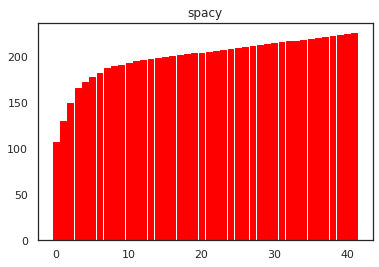

69


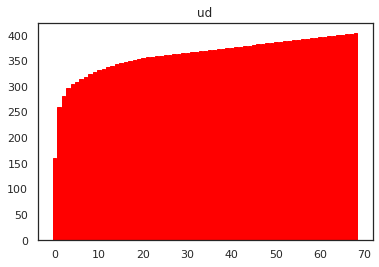

27


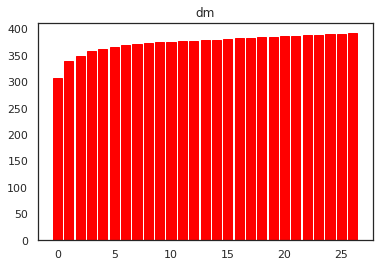

28


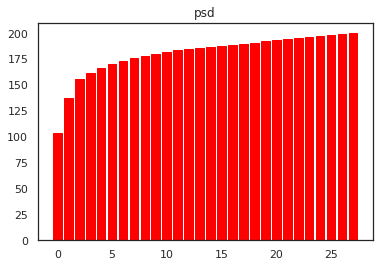

75


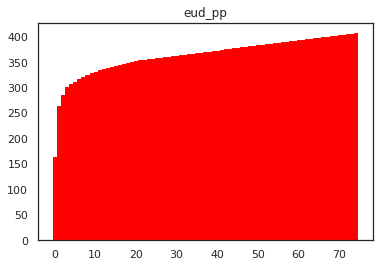

In [728]:
# formalism = ["ud", "dm", "psd"][2]
domain = ['device', 'restaurants', 'laptops'][0]
for formalism in formalisms:
    display_cum_dist_as_bar_chart(deplbl_counters[formalism][domain], title=formalism)

### Path Pattern - Cross-domain Similarity

We want to assess to what extent linguistic information (syntactic vs. semantic information) may facilitate cross-domain generalization w.r.t. the ABSA task. To that end, we will measure how similar are OT\~~AT paths across different domains.

For each formalism, a domain is represented by a probability distribution of path-patterns. We measure the Jensen–Shannon Divergence (JSD) between any two domains, where lower JSD signals a potential for better cross-domain transfer.  

In [32]:
import scipy
from scipy.spatial.distance import jensenshannon as jsd
from itertools import combinations

# convert path-pattern raw data (deplbl_pattern_strs) to a probability distribtuion of patterns
all_patterns_of_formalism = {formalism: list(set().union(*[deplbl_pattern_strs[formalism][domain] 
                                                           for domain in domains])) 

                             for formalism in formalisms}
n_all_patterns = {formalism: len(all_patterns) for formalism, all_patterns in all_patterns_of_formalism.items()}
print("total number of patterns across domains: ", 
      n_all_patterns)
# probabilty distribution for a domain would be a list, where index i is 
# the probability of the pattern all_patterns_of_formalism[formalism][i]
pattern2idx = {formalism: {pattern: idx
                           for idx, pattern in enumerate(all_patterns_of_formalism[formalism])}
               for formalism in formalisms}
pattern_prob_distr =  {formalism: {domain: [deplbl_counters[formalism][domain][pattern] / count_is_directed_path[formalism][domain] 
                                            for pattern in all_patterns_of_formalism[formalism]] 
                                   for domain in domains} 
                       for formalism in formalisms}
assert abs(1-sum(pattern_prob_distr['dm']['device']))<0.00000001, "probability distribution should sum up to 1"

# compute Jensen–Shannon Divergence (JSD) between any two domains
domain_pairs = list(combinations(domains, 2))
jsds = {formalism: {f"{dom1}-{dom2}": jsd(pattern_prob_distr[formalism][dom1], pattern_prob_distr[formalism][dom2], base=2) 
                    for dom1, dom2 in domain_pairs}
        for formalism in formalisms}
display_ndict(jsds)

total number of patterns across domains:  {'spacy': 118, 'ud': 173, 'dm': 68, 'psd': 100, 'eud_pp': 201}


-,device-restaurants,device-laptops,restaurants-laptops,mean
spacy,0.3852,0.4438,0.503,0.444
ud,0.3519,0.4057,0.4363,0.398
dm,0.2063,0.2885,0.2734,0.2561
psd,0.3467,0.4149,0.4736,0.4117
eud_pp,0.3639,0.4147,0.4502,0.4096


## Data Exploration 
Some easy ways to manually "look at the data" - visualize graphs and ABSA terms

In [33]:
def display_graph(g):
    nxg = to_nx(g)
    pattern = deplbl_path_pattern(nxg)
    print("Path Pattern: ", pattern)
    display_absa_graph(g)

    

# Analysis for Multitask Learning approach
In this section we add analyses and data-preparations taylored specifically to the multitask approach we plan to take in order to utilize the linguistic structured for DA-ABSA.

We want the model to predict the “path pattern” between OT and AT (and perhaps, additionally, the identity of corresponding AT, e.g. relative position) in parallel to BIO sequence tagging. For this matter, since we should (I think) formulate the task as a classification problem **per Opinion Term**, we look at OT\~~>AT paths. So we need to reformulate the "pattern" concept.

### Re-defining "indicative graphs"
Now the relvant graphs would be all graphs with at least one Opinion Term (OT). 

In [34]:
# filter indicative graphs 
def graph_has_OT(g: Graph) -> bool:
    """ return true iff sentence have at least one Opinion Term. """
    return len(g.opinion_spans)>0

def graph_has_no_OT(g: Graph) -> bool:
    """ return true iff sentence have no Opinion Term. """
    return len(g.opinion_spans)==0


indicative_sentences_ids = {domain: [i
                                     for i in range(num_sents[domain]) 
                                     if graph_has_OT(all_graphs["ud"][domain][i])]
                            for domain in domains}
all_graphs_with_OT = {formalism: 
                             {domain: 
                                  [all_graphs[formalism][domain][i]
                                   for i in range(num_sents[domain])
                                   if i in indicative_sentences_ids[domain]]
                              for domain in domains}
                         for formalism in formalisms}

all_graphs_without_OT = {formalism: 
                             {domain: 
                                  [all_graphs[formalism][domain][i]
                                   for i in range(num_sents[domain])
                                   if i not in indicative_sentences_ids[domain]]
                              for domain in domains}
                         for formalism in formalisms}

In [35]:
# collect graph with both AT and OT
all_graphs_with_OT_and_AT = {formalism: 
                             {domain: 
                                  [g
                                   for g in all_graphs_with_OT[formalism][domain]
                                   if len(g.aspect_spans)>0]
                              for domain in domains}
                         for formalism in formalisms}

print(f"Overall, we have {count_graphs(all_graphs)} graphs for each of the {len(formalisms)} formalisms")
print(f"collected {count_graphs(all_graphs_with_OT)} graphs with OT.")
print(f"\t Out of which, {count_graphs(all_graphs_with_OT_and_AT)} have also at least one AT.")
print(f"collected {count_graphs(all_graphs_without_OT)} graphs without OTs.")
num_ATs_in_graphs_without_OT = Counter([len(g.aspect_spans) 
                                        for domain in domains
                                        for g in all_graphs_without_OT["ud"][domain]])
                                        
print(f"num_ATs_in_graphs_without_OT: ", num_ATs_in_graphs_without_OT)

num_ATs_in_graphs_with_OT = Counter([len(g.aspect_spans) 
                                        for domain in domains
                                        for g in all_graphs_with_OT["ud"][domain]])
                                        
print(f"num_ATs_in_graphs_with_OT: ", num_ATs_in_graphs_with_OT)

overall_num_ATs = sum(len(g.aspect_spans) 
                                        for domain in domains
                                        for g in all_graphs["ud"][domain]) 
num_AT_without_OT = sum(num_ATs_in_graphs_without_OT.values())-num_ATs_in_graphs_without_OT[0]
print(f"overall #-AT without any OT in same sentence: {num_AT_without_OT}, out of {overall_num_ATs} ATs total " 
      f"({100*num_AT_without_OT/overall_num_ATs:.03}%)")


Overall, we have 13522 graphs for each of the 5 formalisms
collected 7100 graphs with OT.
	 Out of which, 5686 have also at least one AT.
collected 6422 graphs without OTs.
num_ATs_in_graphs_without_OT:  Counter({0: 4906, 1: 1082, 2: 286, 3: 97, 4: 38, 5: 9, 6: 4})
num_ATs_in_graphs_with_OT:  Counter({1: 3431, 2: 1507, 0: 1414, 3: 499, 4: 174, 5: 49, 6: 14, 7: 6, 8: 4, 9: 1, 13: 1})
overall #-AT without any OT in same sentence: 1516, out of 11229 ATs total (13.5%)


## Define "relatedness" from OT to AT
We would have some heuristics by which we define an AT to be "related" (i.e. corresponding) to an OT. 
This heuristics will yield the (OT, AT) pairs consisting of our data, where each OT should appear at least once. 

The most sensible criterion is related to the path on the linguistic graph. 
We can take a maximal path length (undirected) as filter, and then select the most frequenct path patterns if we want a 1-to-1 mapping between OT and AT. 
Look at the path pattern analysis above to determine which patterns look reasonable for a correspondence. 


In [36]:
# Collect all (unrestricted) OT,AT pairs - each OT,AT pair that occur in the same sentence.
# each pair is represnted by a tuple (Graph, OT-span, AT-span).
#   resulting graph-set is equivalent to `all_graphs_with_OT_and_AT`.
#   Note: we will deal with OT having no AT later
from itertools import product
formalisms = ['spacy', 'ud', 'dm', 'psd', "eud_pp"] # let's focus our attention on these formalisms
formalism = "ud"
all_possible_pairs = {formalism: {domain: [(g, op, asp) 
                                           for g in all_graphs[formalism][domain]
                                           for op, asp in product(g.opinion_spans, g.aspect_spans)]
                                  for domain in domains}
                      for formalism in formalisms}


## Path - Re-Definition 
Above, In the Data Analysis Section, we defined a *directed* AT\~\~OT path as a directed path from AT to OT (AT\~\~>OT) *OR* a directed path from OT to AT (OT\~\~>AT), and an *undirected* AT<\~\~>OT path as the path between them on the undirected graph, i.e. when cancelling directionality altogether. 

For our purposes here, we are interested specifically on the directional relation from **OT** toward ATs.
Thus, we define a path OT\~>\~AT to be the description of hops to be taken on the graph from OT to an AT. For this matter, we are allowed to hop across a reversed arc, but this would be distinguished from hopping the standard direction using the relation label, which will be appended a `^-1` marker. E.g. for a graph `X<--a1--Z--a2-->Y` (`a1` and `a2` being the relation labels), there is a path from X to Y (X\~>\~Y), and its `deplbl` pattern would be `[X, a1^-1, Z, a2, Y]`.  

To find this kind of path, we will use the undirected graph and retrieve the nx.shortest_path as list of nodes. Then, we will iterate the original directed graph and recover arc labels (including directionality markers).  

In [37]:
Span = Tuple[int, int] # for typing
Path = Union[List[str], None] # for typing

def get_nx_undirected_path(nxg: nx.DiGraph, opinion: Span, aspect: Span) -> Union[List[int], None]:
    """ 
    Returns the list of nodes on the undirected path from opinion to aspect.   
    """
    nxug = nxg.to_undirected()

    def shortest_path(source, target) -> Path:
        """ source and target are token indices. Return None if no path."""
        try:
            return nx.shortest_path(nxug, source=source, target=target)
        except NetworkXNoPath:
            return None
    all_paths = [shortest_path(source_tokid, target_tokid) 
                 for source_tokid in range(*opinion)
                 for target_tokid in range(*aspect)]
    all_paths = filtered(all_paths) # remove None instances
    if not all_paths:
        return None # no path at all
    shortest_ATOT_path = sorted(all_paths, key=len)[0]
    return shortest_ATOT_path
 
def deplbl_path_pattern(nxg: nx.DiGraph, opinion: Span, aspect: Span) -> Path:
    """ 
    Return the deplbl path-pettern of the shortest OT~~AT path in the graph. 
    Return None if no directed OT~~AT path exists.
    """
    # Comprise the path pattern from representation of nodes and edges along the path
    def node_repr(node_id: int) -> str: 
        """ for `deplbl` patterns, only state whether it is an AT or OT node"""
        if node_id in range(*opinion): return "OT"
        elif node_id in range(*aspect): return "AT"
        else: return "*"
    def edge_repr(u: int, v: int) -> str:
        """ return dependency-label. Assuming (u,v) in nxg.edges. """
        return nxg.edges[(u,v)]['lab']

    path = get_nx_undirected_path(nxg, opinion, aspect) # path is list of nodes (indices)
    if path is None:  # handle no path
        return None
    
    # create and fill the pattern
    pattern = [node_repr(path[0])] # first node
    # iteratively add <edge>, <node> from path
    for i in range(1, len(path)):
        # represent edge - edge might be in reverse direction
        hop = (path[i-1], path[i]) # the next hop in path is from path[i-1] to path[i]
        assert hop in nxg.edges or tuple(reversed(hop)) in nxg.edges, "nx_path contain hops not in DiGraph"
        if hop in nxg.edges: # hop is in standard direction of arc
            pattern.append(edge_repr(*hop))
        else:   # hop is in reverse direction of arc
            pattern.append(edge_repr(*reversed(hop)) + "^-1") # concatenate reverse-dir marker 
        # represent node
        pattern.append(node_repr(path[i])) 
    return pattern
        

In [504]:
# compute average path length per formalism per domain. 
mean_path_length = defaultdict(dict)
dist_path_length = defaultdict(dict) # disribution of path lengths
count_is_path = defaultdict(dict)
list_patterns = defaultdict(dict)
dist_patterns = defaultdict(dict)
num_patterns = defaultdict(dict)
set_of_patterns = defaultdict(dict)
top10_patterns = defaultdict(dict)

for formalism in formalisms:
    for domain in domains:
        shortest_paths = []
        patterns = []
        for g, op, asp in all_possible_pairs[formalism][domain]:
            nxg = to_nx(g)
            nx_path = get_nx_undirected_path(nxg, op, asp) # nx_path is a node list 
            pattern = deplbl_path_pattern(nxg, op, asp)
            if nx_path:
                shortest_paths.append(len(nx_path)-1)
                patterns.append(json.dumps(pattern))
        mean_path_length[formalism][domain] = np.mean(shortest_paths)
        dist_path_length[formalism][domain] = Counter(shortest_paths) 
        count_is_path[formalism][domain] = len(shortest_paths)
        list_patterns[formalism][domain] = patterns
        dist_patterns[formalism][domain] = Counter(patterns)
        set_of_patterns[formalism][domain] = set(patterns)
        num_patterns[formalism][domain] = len(set(patterns))
        top10_patterns[formalism][domain] = dist_patterns[formalism][domain].most_common(10)

In [505]:
# display results in tables
print("#-Graphs for analysis (at least one OT & AT):")
display_ndict(all_graphs_with_OT_and_AT, with_mean = False, pprint=len)
print("#-paths OT~>~AT:")
display_ndict(count_is_path)
print("Mean of shortest path length OT>~>AT (if exists):")
display_ndict(mean_path_length, pprint=lambda s:float(f"{s:.03}"))
print("Distribution (Counter) of shortest path lengths (number of hops / edges, i.e. 1 is minimum) between OT>~>AT:")
display_ndict(dist_path_length, with_mean=False)
print("number of different patterns:")
display_ndict(num_patterns, with_mean=False)
print("Top-10 patterns:")
display_ndict(top10_patterns, with_mean=False)

#-Graphs for analysis (at least one OT & AT):


-,device,restaurants,laptops
spacy,1113,3181,1392
ud,1113,3181,1392
dm,1113,3181,1392
psd,1113,3181,1392
eud_pp,1113,3181,1392


#-paths OT~>~AT:


-,device,restaurants,laptops,mean
spacy,3173,9946,3511,5543.3333
ud,3173,9946,3511,5543.3333
dm,3037,9562,3376,5325.0
psd,3118,9660,3425,5401.0
eud_pp,3173,9946,3511,5543.3333


Mean of shortest path length OT>~>AT (if exists):


-,device,restaurants,laptops,mean
spacy,3.05,3.05,3.04,3.05
ud,2.35,2.24,2.4,2.33
dm,2.6,2.57,2.78,2.65
psd,2.78,2.73,2.72,2.74
eud_pp,2.2,2.09,2.23,2.17


Distribution (Counter) of shortest path lengths (number of hops / edges, i.e. 1 is minimum) between OT>~>AT:


-,device,restaurants,laptops
spacy,"Counter({2: 842, 1: 697, 3: 601, 4: 407, 5: 272, 6: 166, 7: 85, 8: 51, 9: 25, 10: 12, 11: 10, 12: 4, 13: 1})","Counter({2: 2807, 3: 2303, 1: 1766, 4: 1371, 5: 752, 6: 425, 7: 225, 8: 142, 9: 77, 10: 38, 11: 21, 12: 9, 13: 5, 14: 2, 15: 2, 17: 1})","Counter({2: 885, 1: 811, 3: 681, 4: 462, 5: 277, 6: 172, 7: 104, 8: 61, 9: 26, 10: 18, 11: 8, 12: 2, 13: 2, 16: 1, 14: 1})"
ud,"Counter({1: 1178, 2: 808, 3: 597, 4: 328, 5: 139, 6: 68, 7: 26, 8: 12, 9: 8, 10: 3, 11: 3, 12: 2, 13: 1})","Counter({1: 3716, 2: 2858, 3: 1774, 4: 893, 5: 417, 6: 166, 7: 85, 8: 25, 9: 8, 11: 2, 10: 2})","Counter({1: 1306, 2: 874, 3: 612, 4: 378, 5: 176, 6: 88, 7: 44, 8: 19, 9: 8, 10: 3, 11: 1, 12: 1, 14: 1})"
dm,"Counter({1: 1161, 2: 631, 3: 473, 4: 303, 5: 208, 6: 132, 7: 70, 8: 27, 9: 14, 10: 8, 11: 7, 12: 3})","Counter({1: 3772, 2: 1922, 3: 1522, 4: 999, 5: 591, 6: 317, 7: 227, 8: 97, 9: 62, 10: 18, 11: 16, 13: 6, 12: 6, 14: 4, 15: 2, 16: 1})","Counter({1: 1181, 2: 690, 3: 557, 4: 358, 5: 232, 6: 157, 7: 83, 8: 59, 9: 30, 10: 17, 11: 8, 12: 4})"
psd,"Counter({2: 918, 1: 675, 3: 640, 4: 471, 5: 251, 6: 91, 7: 39, 8: 21, 9: 6, 10: 6})","Counter({2: 2934, 1: 2074, 3: 1897, 4: 1605, 5: 752, 6: 251, 7: 103, 8: 33, 10: 5, 9: 4, 11: 2})","Counter({1: 900, 2: 898, 3: 693, 4: 470, 5: 275, 6: 101, 7: 47, 8: 25, 9: 11, 10: 5})"
eud_pp,"Counter({1: 1276, 2: 820, 3: 606, 4: 267, 5: 120, 6: 49, 7: 12, 8: 11, 9: 7, 10: 4, 11: 1})","Counter({1: 4264, 2: 2689, 3: 1684, 4: 791, 5: 321, 6: 120, 7: 56, 8: 13, 9: 5, 11: 2, 10: 1})","Counter({1: 1454, 2: 849, 3: 600, 4: 344, 5: 160, 6: 58, 7: 27, 9: 8, 8: 8, 10: 2, 13: 1})"


number of different patterns:


-,device,restaurants,laptops
spacy,1179,2482,1401
ud,1055,2033,1272
dm,880,2014,1099
psd,820,1813,1049
eud_pp,987,1979,1238


Top-10 patterns:


-,device,restaurants,laptops
spacy,"[('[""OT"", ""amod^-1"", ""AT""]', 410), ('[""OT"", ""acomp^-1"", ""*"", ""nsubj"", ""AT""]', 373), ('[""OT"", ""xcomp"", ""AT""]', 95), ('[""OT"", ""prep"", ""*"", ""pobj"", ""AT""]', 49), ('[""OT"", ""advmod^-1"", ""AT""]', 44), ('[""OT"", ""amod^-1"", ""*"", ""conj"", ""AT""]', 41), ('[""OT"", ""dobj"", ""AT""]', 40), ('[""OT"", ""acomp^-1"", ""*"", ""conj^-1"", ""*"", ""nsubj"", ""AT""]', 40), ('[""OT"", ""amod^-1"", ""*"", ""prep"", ""*"", ""pobj"", ""AT""]', 36), ('[""OT"", ""amod^-1"", ""*"", ""conj^-1"", ""AT""]', 33)]","[('[""OT"", ""acomp^-1"", ""*"", ""nsubj"", ""AT""]', 1491), ('[""OT"", ""amod^-1"", ""AT""]', 1308), ('[""OT"", ""acomp^-1"", ""*"", ""conj"", ""*"", ""nsubj"", ""AT""]', 235), ('[""OT"", ""acomp^-1"", ""*"", ""conj^-1"", ""*"", ""nsubj"", ""AT""]', 227), ('[""OT"", ""conj^-1"", ""*"", ""acomp^-1"", ""*"", ""nsubj"", ""AT""]', 224), ('[""OT"", ""amod^-1"", ""*"", ""conj"", ""AT""]', 175), ('[""OT"", ""dobj"", ""AT""]', 166), ('[""OT"", ""prep"", ""*"", ""pobj"", ""AT""]', 147), ('[""OT"", ""amod^-1"", ""*"", ""conj^-1"", ""AT""]', 139), ('[""OT"", ""amod^-1"", ""*"", ""prep"", ""*"", ""pobj"", ""AT""]', 114)]","[('[""OT"", ""amod^-1"", ""AT""]', 355), ('[""OT"", ""acomp^-1"", ""*"", ""nsubj"", ""AT""]', 267), ('[""OT"", ""prep"", ""*"", ""pobj"", ""AT""]', 109), ('[""OT"", ""nsubj"", ""AT""]', 90), ('[""OT"", ""dobj"", ""AT""]', 80), ('[""OT"", ""advmod^-1"", ""AT""]', 57), ('[""OT"", ""amod^-1"", ""*"", ""conj"", ""AT""]', 45), ('[""OT"", ""xcomp"", ""AT""]', 44), ('[""OT"", ""amod^-1"", ""*"", ""prep"", ""*"", ""pobj"", ""AT""]', 34), ('[""OT"", ""conj"", ""AT""]', 27)]"
ud,"[('[""OT"", ""amod^-1"", ""AT""]', 377), ('[""OT"", ""nsubj"", ""AT""]', 367), ('[""OT"", ""conj^-1"", ""*"", ""nsubj"", ""AT""]', 77), ('[""OT"", ""amod^-1"", ""*"", ""conj^-1"", ""*"", ""conj"", ""AT""]', 59), ('[""OT"", ""amod^-1"", ""*"", ""conj"", ""AT""]', 52), ('[""OT"", ""ccomp"", ""AT""]', 50), ('[""OT"", ""obl"", ""AT""]', 47), ('[""OT"", ""advmod^-1"", ""AT""]', 44), ('[""OT"", ""obj"", ""AT""]', 42), ('[""OT"", ""advcl"", ""AT""]', 40)]","[('[""OT"", ""nsubj"", ""AT""]', 1544), ('[""OT"", ""amod^-1"", ""AT""]', 1301), ('[""OT"", ""conj^-1"", ""*"", ""nsubj"", ""AT""]', 548), ('[""OT"", ""conj"", ""*"", ""nsubj"", ""AT""]', 256), ('[""OT"", ""amod^-1"", ""*"", ""conj"", ""AT""]', 200), ('[""OT"", ""obl"", ""AT""]', 175), ('[""OT"", ""obj"", ""AT""]', 168), ('[""OT"", ""amod^-1"", ""*"", ""conj^-1"", ""AT""]', 148), ('[""OT"", ""conj^-1"", ""*"", ""conj"", ""*"", ""nsubj"", ""AT""]', 118), ('[""OT"", ""amod^-1"", ""*"", ""conj^-1"", ""*"", ""conj"", ""AT""]', 115)]","[('[""OT"", ""nsubj"", ""AT""]', 351), ('[""OT"", ""amod^-1"", ""AT""]', 344), ('[""OT"", ""obl"", ""AT""]', 83), ('[""OT"", ""obj"", ""AT""]', 80), ('[""OT"", ""conj"", ""AT""]', 63), ('[""OT"", ""conj^-1"", ""*"", ""nsubj"", ""AT""]', 61), ('[""OT"", ""advmod^-1"", ""AT""]', 57), ('[""OT"", ""amod^-1"", ""*"", ""conj"", ""AT""]', 52), ('[""OT"", ""nmod"", ""AT""]', 46), ('[""OT"", ""conj"", ""*"", ""nsubj"", ""AT""]', 38)]"
dm,"[('[""OT"", ""ARG1"", ""AT""]', 991), ('[""OT"", ""ARG2"", ""AT""]', 75), ('[""OT"", ""ARG1"", ""*"", ""ARG2^-1"", ""*"", ""ARG1"", ""AT""]', 75), ('[""OT"", ""ARG1"", ""*"", ""ARG2"", ""AT""]', 72), ('[""OT"", ""ARG1"", ""*"", ""ARG1^-1"", ""*"", ""ARG2"", ""AT""]', 64), ('[""OT"", ""ARG1"", ""*"", ""ARG1"", ""AT""]', 60), ('[""OT"", ""ARG2^-1"", ""*"", ""ARG1"", ""AT""]', 44), ('[""OT"", ""ARG1^-1"", ""*"", ""ARG2"", ""AT""]', 43), ('[""OT"", ""ARG1"", ""*"", ""_and_c"", ""AT""]', 42), ('[""OT"", ""_and_c^-1"", ""*"", ""ARG1"", ""AT""]', 34)]","[('[""OT"", ""ARG1"", ""AT""]', 3276), ('[""OT"", ""ARG2"", ""AT""]', 308), ('[""OT"", ""ARG1^-1"", ""*"", ""ARG2"", ""AT""]', 179), ('[""OT"", ""ARG1"", ""*"", ""ARG2^-1"", ""*"", ""ARG1"", ""AT""]', 171), ('[""OT"", ""ARG1"", ""*"", ""ARG1^-1"", ""*"", ""ARG2"", ""AT""]', 169), ('[""OT"", ""_and_c"", ""*"", ""ARG1"", ""AT""]', 158), ('[""OT"", ""ARG1"

In [40]:
# put all data in DataFrame
headers = ["formalism", "domain", "graph", "sentence", "opinion_span", "aspect_span", "pattern"]
records = [(formalism, domain, g, g.input, op, asp, deplbl_path_pattern(to_nx(g), op, asp)) 
           for formalism in formalisms
           for domain in domains 
           for g,op,asp in all_possible_pairs[formalism][domain]]
df = pd.DataFrame(records, columns=headers)

In [41]:
# compute overlap in patterns
pattern_overlap_set = {formalism: {(dom1, dom2): set_of_patterns[formalism][dom1] & set_of_patterns[formalism][dom2]
                                   for dom1, dom2 in permutations(domains, 2)} 
                       for formalism in formalisms}
# count #-instances in dom1 included in overlap with dom2
pattern_overlap_amount = {formalism: {(dom1, dom2): list_patterns[formalism][dom1].count(
    lambda e: e in pattern_overlap_set[formalism][(dom1, dom2)]) 
                                      for dom1, dom2 in permutations(domains, 2)} 
                          for formalism in formalisms}
pattern_overlap_ratio = {formalism: {(dom1, dom2): pattern_overlap_amount[formalism][(dom1,dom2)] / len(list_patterns[formalism][dom1])
                                     for dom1, dom2 in permutations(domains, 2)} 
                         for formalism in formalisms}
print("Cross-domain relative path-pattern overalp:")
display_ndict(pattern_overlap_ratio)

Cross-domain relative path-pattern overalp:


-,"('device', 'restaurants')","('device', 'laptops')","('restaurants', 'device')","('restaurants', 'laptops')","('laptops', 'device')","('laptops', 'restaurants')",mean
spacy,0.6662,0.6889,0.7006,0.7143,0.6326,0.6619,0.6774
ud,0.7441,0.7286,0.7578,0.7603,0.6839,0.7123,0.7312
dm,0.7965,0.7557,0.7574,0.76,0.721,0.7521,0.7571
psd,0.77,0.7399,0.7344,0.7365,0.6768,0.7194,0.7295
eud_pp,0.7296,0.7148,0.7474,0.7502,0.6611,0.6858,0.7148


## "Relatedness" Definition
### preliminary analysis
We want to explore how many path instances are covered within each optional heuristic critrion for "relatedness".

**Notice** that this is counting "naive" coverage - counting how many of *all possible (OT,AT) pairs* are covered (where clearly many such pairs are unrelated).

#### Path Length pruning heuristic

In [42]:
# How many instances are covered in each path length? 
# --> we already have this information as Counters in `dist_path_length`, 

# present it neetly - proportional coverage, accumulative
proportion_covered_by_length = defaultdict(dict)
for formalism in formalisms:
    for domain in domains:
        c = dist_path_length[formalism][domain]
        proportion_covered_by_length[formalism][domain] = counter_as_accumulative(counter_as_relative(c)) 
display_ndict(proportion_covered_by_length, with_mean=False)
        

-,device,restaurants,laptops
spacy,"{2: 0.21966593129530412, 3: 0.4850299401197605, 4: 0.6744405924992122, 5: 0.8027103687362118, 6: 0.8884336589977939, 7: 0.9407500787897889, 8: 0.9675386069965333, 9: 0.9836117239205799, 10: 0.9914907028049166, 11: 0.9952726126693981, 12: 0.9984242042231328, 13: 0.9996848408446267, 14: 1.0000000000000002}","{2: 0.17755881761512166, 3: 0.4597828272672431, 4: 0.6913331992760909, 5: 0.8291775588176151, 6: 0.9047858435551981, 7: 0.9475165895837523, 8: 0.970138749245928, 9: 0.9844158455660568, 10: 0.9921576513171124, 11: 0.9959782827267243, 12: 0.9980896842951941, 13: 0.9989945706816811, 14: 0.9994972853408405, 15: 0.9996983712045042, 16: 0.999899457068168, 18: 0.9999999999999999}","{2: 0.23098832241526632, 3: 0.48305326117915126, 4: 0.6770150954144118, 5: 0.8086015380233551, 6: 0.8874964397607519, 7: 0.9364853318142978, 8: 0.9661065223583024, 9: 0.9834804898889205, 10: 0.9908857875249216, 11: 0.9960125320421532, 12: 0.9982910851609228, 13: 0.9988607234406152, 14: 0.9994303617203075, 15: 0.9997151808601538, 17: 1.0}"
ud,"{2: 0.3712574850299401, 3: 0.6259060825716987, 4: 0.8140560983296564, 5: 0.9174283012921525, 6: 0.9612354238890639, 7: 0.9826662464544594, 8: 0.9908603844941695, 9: 0.994642294358651, 10: 0.9971635676016387, 11: 0.9981090450677591, 12: 0.9990545225338795, 13: 0.9996848408446264, 14: 0.9999999999999999}","{2: 0.37361753468731146, 3: 0.6609692338628594, 4: 0.8393323949326362, 5: 0.929117233058516, 6: 0.971043635632415, 7: 0.9877337623165091, 8: 0.99627991152222, 9: 0.9987934848180172, 10: 0.9995978282726724, 11: 0.9997989141363361, 12: 0.9999999999999999}","{2: 0.37197379663913416, 3: 0.620905724864711, 4: 0.7952150384505839, 5: 0.9028766733124467, 6: 0.9530048419253775, 7: 0.9780689262318429, 8: 0.9906009683850756, 9: 0.9960125320421533, 10: 0.9982910851609229, 11: 0.9991455425804615, 12: 0.9994303617203077, 13: 0.999715180860154, 15: 1.0000000000000002}"
dm,"{2: 0.3822851498189002, 3: 0.5900559762923938, 4: 0.7458017780704642, 5: 0.845571287454725, 6: 0.9140599275600921, 7: 0.9575238722423444, 8: 0.980572933816266, 9: 0.9894632861376358, 10: 0.9940730984524201, 11: 0.9967072769180111, 12: 0.9990121830754033, 13: 0.9999999999999999}","{2: 0.3944781426479816, 3: 0.5954821167119849, 4: 0.7546538381091822, 5: 0.8591298891445305, 6: 0.9209370424597365, 7: 0.9540891026981804, 8: 0.9778289060865928, 9: 0.9879732273582933, 10: 0.9944572265216483, 11: 0.9963396778916546, 12: 0.9980129679983268, 13: 0.9986404517883289, 14: 0.999267935578331, 15: 0.9996862581049991, 16: 0.9998954193683331, 17: 1.0000000000000002}","{2: 0.34982227488151657, 3: 0.5542061611374407, 4: 0.7191943127962085, 5: 0.8252369668246445, 6: 0.893957345971564, 7: 0.9404620853080569, 8: 0.965047393364929, 9: 0.9825236966824645, 10: 0.9914099526066351, 11: 0.9964454976303317, 12: 0.9988151658767772, 13: 1.0}"
psd,"{2: 0.21648492623476587, 3: 0.5109044259140475, 4: 0.7161642078255293, 5: 0.8672225785760104, 6: 0.9477228992944196, 7: 0.9769082745349583, 8: 0.9894162924951893, 9: 0.9961513790891597, 10: 0.9980756895445799, 11: 1.0}","{2: 0.21469979296066252, 3: 0.5184265010351967, 4: 0.7148033126293996, 5: 0.8809523809523809, 6: 0.9587991718426501, 7: 0.9847826086956522, 8: 0.9954451345755694, 9: 0.9988612836438924, 10: 0.9992753623188406, 11: 0.9997929606625259, 12: 1.0}","{2: 0.26277372262773724, 3: 0.5249635036496351, 4: 0.7272992700729928, 5: 0.8645255474452556, 6: 0.9448175182481753, 7: 0.9743065693430658, 8: 0.9880291970802921, 9: 0.9953284671532848, 10: 0.9985401459854016, 11: 1.0000000000000002}"
eud_pp,"{2: 0.40214308225653955, 3: 0.6605735896627797, 4: 0.8515600378190986, 5: 0.9357075323038134, 6: 0.973526630948629, 7: 0.9889694295619287, 8: 0.9927513394264103, 9: 0.9962180901355183, 10: 0.9984242042231326, 11: 0.9996848408446265, 12: 1.0}","{2: 0.4287150613311884, 3: 0.6990750050271466, 4: 0.868389302232053, 5: 0.9479187613110798, 6: 0.9801930424291172, 7: 0.9922581942489442, 8: 0.9978885984315302, 9: 0.9991956565453

Probably better to assess the following - 
among relevant graphs (with >1 AT & >1 OT, i.e. `all_graphs_with_OT_and_AT`), assuming there truly is a 1to1 mapping between AT and OT, how many potential pairs (excluding repetitions) are covered?

In [43]:
# Add a `potential_pair_count` property to all relevant graphs (those in `all_graphs_with_OT_and_AT`).
# This property will quantify how many true (OT,AT) pairs should approximately in the graph.
# We will later use it to assess relative coverage of paths.
potential_pair_sum = defaultdict(dict)
approx_proportion_covered_by_length = defaultdict(dict) 

for formalism in formalisms:
    for domain in domains:
        summ = 0
        for g in all_graphs_with_OT_and_AT[formalism][domain]:
            g.potential_pair_count = min(len(g.opinion_spans), len(g.aspect_spans))
            summ += g.potential_pair_count 
        potential_pair_sum[formalism][domain] = summ
        # re-calculate covergae - now, relative to potential matching pairs
        accum_counter = counter_as_accumulative(dist_path_length[formalism][domain])
        # `accum_counter` counts {i: how many paths are longer than i}
        p = {k: v/summ for k,v in accum_counter.items() if v/summ<=1.5}
        approx_proportion_covered_by_length[formalism][domain] = p
        
display_ndict(approx_proportion_covered_by_length, with_mean=False)

-,device,restaurants,laptops
spacy,"{2: 0.4783802333562114, 3: 1.0562800274536719, 4: 1.4687714481811942}","{2: 0.4049529924329282, 3: 1.0486127035083697}","{2: 0.473714953271028, 3: 0.9906542056074766, 4: 1.3884345794392523}"
ud,"{2: 0.8085106382978723, 3: 1.3630748112560054}",{2: 0.8520981426278377},"{2: 0.7628504672897196, 3: 1.2733644859813085}"
dm,"{2: 0.7968428277282087, 3: 1.2299245024021963}","{2: 0.8649392341206146, 3: 1.3056638385691355}","{2: 0.6898364485981309, 3: 1.092873831775701, 4: 1.4182242990654206}"
psd,"{2: 0.46328071379547014, 3: 1.0933424845573096}","{2: 0.4755789956432011, 3: 1.1483604677826187}","{2: 0.5257009345794392, 3: 1.050233644859813, 4: 1.4550233644859814}"
eud_pp,"{2: 0.8757721345229924, 3: 1.4385724090597118}",{2: 0.9777573950928686},"{2: 0.8492990654205608, 3: 1.3452102803738317}"


### Action: Prune by path length
*Conclusion*:  pruning with path-length<=2-hops seems reasonable!

Generating `all_related_pairs` for better further analyses (and making the analysis on the way).

In [558]:
NUM_HOPS_THESHOLD = 2 # path with more hops will be pruned away from `all_related_pairs`

all_related_pairs = defaultdict(dict)
list_patterns = defaultdict(dict)
dist_patterns = defaultdict(dict)
num_patterns = defaultdict(dict)
set_of_patterns = defaultdict(dict)
top10_patterns = defaultdict(dict)

for formalism in formalisms:
    for domain in domains:
        relevant_pairs = []
        patterns = []
        for g, op, asp in all_possible_pairs[formalism][domain]:
            nxg = to_nx(g)
            nx_path = get_nx_undirected_path(nxg, op, asp) # nx_path is a node list, so len(path) is 1 + num_hops
            if nx_path and len(nx_path) <= 1+NUM_HOPS_THESHOLD: 
                relevant_pairs.append((g, op, asp))
                pattern = deplbl_path_pattern(nxg, op, asp)
                patterns.append(json.dumps(pattern))
        all_related_pairs[formalism][domain] = relevant_pairs
        list_patterns[formalism][domain] = patterns
        dist_patterns[formalism][domain] = Counter(patterns)
        set_of_patterns[formalism][domain] = set(patterns)
        num_patterns[formalism][domain] = len(set(patterns))
        top10_patterns[formalism][domain] = dist_patterns[formalism][domain].most_common(10)

In [423]:
################### find nice examples for illustration ############
pattern2graphs = defaultdict(dict) # map pattern-string to list of graphs (cross-domain)

for formalism in formalisms:
    for domain in domains:
        pattern2graphs[formalism][domain] = defaultdict(list)
        patterns = []
        for g, op, asp in all_possible_pairs[formalism][domain]:
            pattern = deplbl_path_pattern(to_nx(g), op, asp)
            patterns.append(pattern)
            if pattern:
                pattern2graphs[formalism][domain][repr(pattern)].append((g, op, asp))


In [748]:
# pattern2graphs["spacy"]["device"]["['OT', 'acomp^-1', '*', 'nsubj', 'AT']"][1]
g, op, asp = pattern2graphs["ud"]["device"]["['OT', 'conj^-1', '*', 'nsubj', 'AT']"][14]
dev_op_to_trip = {g.input.split()[op[0]]: (g, op, asp) 
                  for g, op, asp in pattern2graphs["ud"]["device"]["['OT', 'conj^-1', '*', 'nsubj', 'AT']"]}
res_op_to_trip = {g.input.split()[op[0]]: (g, op, asp) 
                  for g, op, asp in pattern2graphs["ud"]["restaurants"]["['OT', 'conj^-1', '*', 'nsubj', 'AT']"]}

print(set(res_op_to_trip.keys()) & set(dev_op_to_trip.keys())) 

def graph_to_tikz_dependency(g, op, asp):
    s = """\\begin{dependency}[theme=iron, edge theme=copper, label theme=copper] 
    \\begin{deptext}\n"""
    s += " \\& ".join(g.input.split()) + " \\\\ \n"
    s += "\\end{deptext}\n"
    s += "\n".join(f"\\depedge{{{e.src+1}}}{{{e.tgt+1}}}{{{e.lab}}} " for e in g.edges) + "\n"
    s += f"\\wordgroup[group style={{fill=blue!20, draw=brown}}]{{1}}{{{asp[0]+1}}}{{{asp[0]+1}}}{{aspect}}" + "\n"
    s += f"\\wordgroup[group style={{fill=yellow!50, draw=brown}}]{{1}}{{{op[0]+1}}}{{{op[0]+1}}}{{opinion}}" + "\n"
    s += "\\end{dependency}"
    return s

word = "loud"
g, op, asp = dev_op_to_trip[word]
print(g.input, "asp:", asp, g.input.split()[asp[0]], "op:", op, g.input.split()[op[0]])
print(graph_to_tikz_dependency(g, op, asp))
print()
g, op, asp = res_op_to_trip["quiet"]
print(g.input, "asp:", asp, g.input.split()[asp[0]], "op:", op, g.input.split()[op[0]])
print(graph_to_tikz_dependency(g, op, asp))

{'uncomfortable', 'better', 'recommend', 'great', 'bad', 'small', 'cool', 'excellent', 'loud', 'good', 'love', 'beautiful', 'quick'}
but the sound is very good ( and loud ) and works well on my portable speakers . asp: (2, 3) sound op: (8, 9) loud
\begin{dependency}[theme=iron, edge theme=copper, label theme=copper] 
    \begin{deptext}
but \& the \& sound \& is \& very \& good \& ( \& and \& loud \& ) \& and \& works \& well \& on \& my \& portable \& speakers \& . \\ 
\end{deptext}
\depedge{6}{7}{punct} 
\depedge{12}{13}{advmod} 
\depedge{12}{11}{cc} 
\depedge{6}{4}{cop} 
\depedge{17}{14}{case} 
\depedge{17}{16}{amod} 
\depedge{6}{3}{nsubj} 
\depedge{6}{5}{advmod} 
\depedge{12}{17}{obl} 
\depedge{3}{2}{det} 
\depedge{6}{10}{punct} 
\depedge{6}{1}{cc} 
\depedge{6}{9}{conj} 
\depedge{17}{15}{nmod:poss} 
\depedge{9}{8}{cc} 
\depedge{6}{12}{conj} 
\depedge{6}{18}{punct} 
\wordgroup[group style={fill=blue!20, draw=brown}]{1}{3}{3}{aspect}
\wordgroup[group style={fill=yellow!50, draw=brown

In [726]:
for i, (g, op, asp) in enumerate(pattern2graphs["ud"]["laptops"]["['OT', 'conj^-1', '*', 'nsubj', 'AT']"][:20]):
    print(i, g.input, "asp:", asp, g.input.split()[asp[0]], "op:", op, g.input.split()[op[0]])

0 Keyboard is great , very quiet for all the typing that I do . asp: (0, 1) Keyboard op: (5, 6) quiet
1 keys are all in weird places and is way too large for the way it is designed . asp: (0, 1) keys op: (10, 11) large
2 I wish the volume could be louder and the mouse didnt break after only a month . asp: (3, 4) volume op: (11, 12) break
3 The screen is very large and crystal clear with amazing colors and resolution . asp: (1, 2) screen op: (6, 8) crystal
4 The screen is bright and the keyboard is nice ; asp: (1, 2) screen op: (8, 9) nice
5 iTunes is a handy music-management program , and it is essential for anyone with an iPod . asp: (0, 1) iTunes op: (10, 11) essential
6 the programs are esay to use and are quick to process this computer works like a charm . asp: (1, 2) programs op: (8, 9) quick
7 The price premium is a little much , but when you start looking at the features it is worth the added cash . asp: (1, 3) price op: (18, 19) worth
8 Windows is also rather unsteady on its fe

In [45]:
# display results in tables
print("#-Graphs for analysis (at least one OT & AT):")
display_ndict(all_graphs_with_OT_and_AT, with_mean = False, pprint=len)
print("#-Triplets (g, op, asp) potential (all possible - i.e. within the same sentence):")
display_ndict(all_possible_pairs, with_mean = False, pprint=len)
print("#-Triplets (g, op, asp) filtered as related:")
display_ndict(all_related_pairs, with_mean = False, pprint=len)
print("number of different patterns:")
display_ndict(num_patterns, with_mean=False)

# Compute aggregated percent of triplets from "all possible" covered as "related" 
percent_related = {formalism: np.mean([len(all_related_pairs[formalism][domain])/len(all_possible_pairs[formalism][domain]) 
                                       for domain in domains])
                   for formalism in formalisms}
print(f'percent of triplets from "all possible" covered as "related": {percent_related}')
print(f'\t Mean across formalisms: {np.mean(list(percent_related.values()))}' )

#-Graphs for analysis (at least one OT & AT):


-,device,restaurants,laptops
spacy,1113,3181,1392
ud,1113,3181,1392
dm,1113,3181,1392
psd,1113,3181,1392
eud_pp,1113,3181,1392


#-Triplets (g, op, asp) potential (all possible - i.e. within the same sentence):


-,device,restaurants,laptops
spacy,3173,9946,3511
ud,3173,9946,3511
dm,3173,9946,3511
psd,3173,9946,3511
eud_pp,3173,9946,3511


#-Triplets (g, op, asp) filtered as related:


-,device,restaurants,laptops
spacy,1539,4573,1696
ud,1986,6574,2180
dm,1792,5694,1871
psd,1593,5008,1798
eud_pp,2096,6953,2303


number of different patterns:


-,device,restaurants,laptops
spacy,120,164,167
ud,212,277,243
dm,109,146,108
psd,125,242,191
eud_pp,283,435,339


percent of triplets from "all possible" covered as "related": {'spacy': 0.47595534285538493, 'ud': 0.635927013766423, 'dm': 0.5567177569774256, 'psd': 0.5058907835225023, 'eud_pp': 0.6718623579185731}
	 Mean across formalisms: 0.5692706510080618


In [598]:
# compute overlap in patterns
pattern_overlap_set = {formalism: {(dom1, dom2): set_of_patterns[formalism][dom1] & set_of_patterns[formalism][dom2]
                                   for dom1, dom2 in permutations(domains, 2)} 
                       for formalism in formalisms}
# count #-instances in dom2 included in overlap with dom1
pattern_overlap_amount = {formalism: {(dom1, dom2): list_patterns[formalism][dom2].count(
    lambda e: e in pattern_overlap_set[formalism][(dom1, dom2)]) 
                                      for dom1, dom2 in permutations(domains, 2)} 
                          for formalism in formalisms}
pattern_overlap_ratio = {formalism: {(dom1, dom2): pattern_overlap_amount[formalism][(dom1,dom2)] / len(list_patterns[formalism][dom2])
                                     for dom1, dom2 in permutations(domains, 2)} 
                         for formalism in formalisms}
print("Cross-domain relative path-pattern overalp:")
display_ndict(pattern_overlap_ratio, pprint=lambda x:f"{x*100:.1f}", with_mean=False)

Cross-domain relative path-pattern overalp:


-,"('restaurants', 'laptops')","('restaurants', 'device')","('laptops', 'restaurants')","('laptops', 'device')","('device', 'restaurants')","('device', 'laptops')"
spacy,89.9,87.4,97.5,96.8,95.3,93.0
ud,93.4,94.0,96.7,95.9,95.7,93.1
dm,97.8,97.9,97.9,97.0,97.3,97.1
psd,93.8,95.5,95.3,96.8,93.2,90.4
eud_pp,89.4,91.2,93.1,92.0,92.3,88.7



#### Top-k patterns heuristics

164


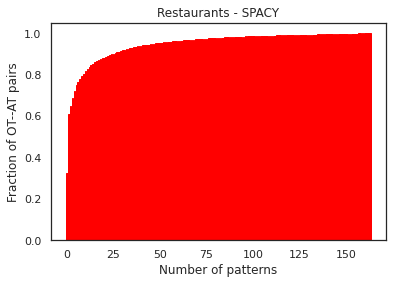

277


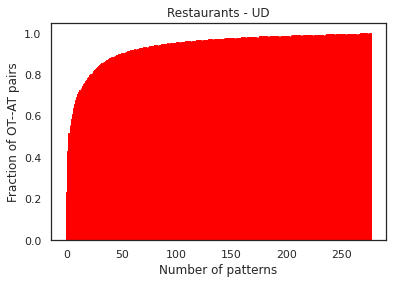

146


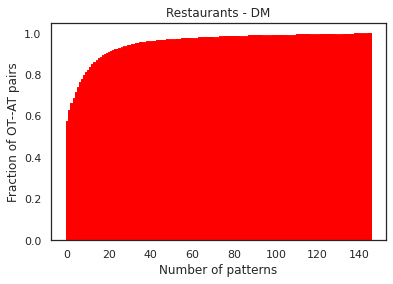

242


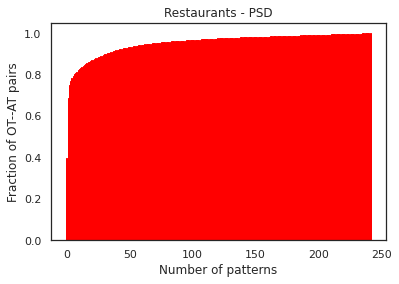

In [783]:
# def display_cum_dist_as_bar_chart(counter: Dict[Any, Numeric], 
#                                   ax,
#                                   title: str = '',
#                                   save_as=None,
#                                   xlabel = '',
#                                   ylabel = '',
#                                   show=True):
#     print(len(counter))
#     # plot_bar_with_long_labels(*zip(*deplbl_top10[formalism][domain]), title=formalism)
#     data = sorted(counter.values(), reverse=True)
#     cum = np.cumsum(data)
# #     ax = plt.subplot(1,4, subplot_index)
#     ax.bar(np.arange(len(cum)), cum, color = 'red', edgecolor = 'red')
#     ax.set_title(title)
#     if xlabel:
#         ax.xlabel(xlabel)
#     if ylabel:
#         ax.ylabel(ylabel)
#     if save_as:
#         ax.savefig(save_as)
#     if show:
#         ax.show()
        
# collect the overall pattern distribution across domains
pattern_dist_across_domains = {formalism: sum([dist_patterns[formalism][domain] for domain in domains], Counter())
                               for formalism in formalisms}

# fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(24, 14))
domain = "restaurants"
for i, formalism in enumerate(formalisms[:4]):
    relative = counter_as_relative(dist_patterns[formalism][domain])
    display_cum_dist_as_bar_chart(relative, 
                                  title=f"{domain.title()} - {formalism.upper()}",
                                  save_as=f"pattern_cum_distribution_{formalism}_{domain}.jpg",
                                  xlabel="Number of patterns",
                                  ylabel="Fraction of OT--AT pairs")
# fig.tight_layout()
# fig.show()

In [ ]:
fig.savefig("pattern_cum_distribution_all.png")

**Conclusion**: *Top-k patterns* is quite a "wide-covering" heuristic - with K=25 we get ~80-85% for PSD,DM and spacy or around 70-75% for UD and EUD.  With K=100 we get up 92%-98% (87% for EUD) coverage, which is not bad. 
However, selecting top-k pattern and leaving the rest of patterns as UNK_PATTERN will leave out a lot of information.  

#### Reducing \ Clustering the pattern-space 
We suggest two reductions for pattern space:

* `trimmed_pattern`: The label would be a representation of **first two hops**, while next hops are totally "anonimized", i.e. labels just denotes "another-hop" with direction. We may call this shortened pattern `trim_patt` for short .
* `bare_pattern`: The label would only represent the direction of edges in the path, stripping out dependency label. 

In [47]:
top10_patterns["spacy"]["device"][:4].map(lambda a:a[0][:10])

['["OT", "am', '["OT", "ac', '["OT", "xc', '["OT", "pr']

In [48]:
def label2pure_direction(lbl: str) -> str:
    return "<-" if "^-1" in lbl else "->"

def pattern_to_trimmed_pattern(pattern: Union[List[str], str]) -> Union[List[str], str]:
    # handle also string representation of patterns
    as_str = isinstance(pattern, str)
    if as_str:
        pattern = json.loads(pattern)
    # trim 
    # (1) take first 2 hops
    trimmed = pattern[:4]
    # (2) "anonimize" rest of hops - keep directionality of dep-labels
    anon_element = lambda s: "*" if s is "*" else label2pure_direction(s)
    if len(pattern) > 4:
        trimmed += list(map(anon_element, pattern[4:-1])) + pattern[-1:]
    # restore to str if input was str
    if as_str:
        trimmed = json.dumps(trimmed)
    return trimmed


def pattern_to_bare_pattern(pattern: Union[List[str], str]) -> Union[List[str], str]:
    # handle also string representation of patterns
    as_str = isinstance(pattern, str)
    if as_str:
        pattern = json.loads(pattern)
    # strip out labels, keeping only directionality 
    element_to_bare = lambda s: s if s in ("*", "AT", "OT") else label2pure_direction(s)
    bared = list(map(element_to_bare, pattern)) 
    # restore to str if input was str
    if as_str:
        bared = json.dumps(bared)
    return bared

In [49]:
# test
for patt in list_patterns["ud"]["laptops"][12:16]:
    trim = pattern_to_trimmed_pattern(patt)
    bare = pattern_to_bare_pattern(patt)
    print(f"pattern: {pattern}")
    print(f"trimmed: {trim}")
    print(f"bare: {bare}")
    print()

pattern: ['OT', 'advcl:in^-1', '*', 'nsubj:xcomp(INF)', 'AT']
trimmed: ["OT", "amod^-1", "AT"]
bare: ["OT", "<-", "AT"]

pattern: ['OT', 'advcl:in^-1', '*', 'nsubj:xcomp(INF)', 'AT']
trimmed: ["OT", "det^-1", "AT"]
bare: ["OT", "<-", "AT"]

pattern: ['OT', 'advcl:in^-1', '*', 'nsubj:xcomp(INF)', 'AT']
trimmed: ["OT", "det^-1", "*", "compound^-1", "AT"]
bare: ["OT", "<-", "*", "<-", "AT"]

pattern: ['OT', 'advcl:in^-1', '*', 'nsubj:xcomp(INF)', 'AT']
trimmed: ["OT", "conj", "*", "obl:npmod", "AT"]
bare: ["OT", "->", "*", "->", "AT"]



# Analysing the Pivot Approach Potential

Since a lot of our ideas is based on the thought that Opinion Terms can serve as pivots for generalizing Aspect Term Extraction across domains, here we shall test this underlying assumption. 

We wish to quantify how many of the apsect terms in a target domain T are extractable based on the OT->-AT path pattern in source domain S. Our "predictor" is deterministically applying the top K path-patterns from S and retrieving all possible tokens that match this pattern as predicted AT.  Specifically, we measure what is the *recall* and *precision* of this approach for K $\in$ \[1,3,5,10,25,50,100\] for each formalism. 

(We can also decide to select P $\in$ (0,1) instead of K, where `K <- num-pattern * P`; or instead select theshold T for taking pattern occuring more than T times)


In [53]:

# **** Per instance prediction function ****
def extract_by_patterns(g, ot_span, patterns) -> Set[int]:
    """ Given an instance, return the predicted "aspect terms" tokens """
    def pattern2hops(pattern: str) -> List[Tuple[str,str]]:
        """ E.g '["OT", "acomp^-1", "*", "nsubj", "AT"]' -> [('acomp', 'in'), ('nsubj', 'out')] """
        pattern = json.loads(pattern)
        edge2hop = lambda e: (e, "out") if "^-1" not in e else (e.rstrip("^-1"), "in")
        hops = [edge2hop(pattern[i]) for i in range(1,len(pattern),2)]
        return hops

    def follow_hop(g, src_node, hop) -> List[Node]:
        lbl, dir = hop
        edges = {"in": src_node.incoming_edges, "out": src_node.outgoing_edges}[dir]
        matching_edges = filter(lambda e:e.lab==lbl, edges)
        if dir=="out":
            return [g.find_node(e.tgt) for e in matching_edges]
        else:
            return [g.find_node(e.src) for e in matching_edges]

    def follow_path(g, src_node, hops) -> List[Node]: 
        """ Returns all target nodes (ids) that match the path pattern from src_node. """
        hop, next_hops = hops[0], hops[1:]
        next_nodes = follow_hop(g, src_node, hop)
        if not next_hops: # -- end of route
            return next_nodes
        else:
            dests = []
            for next_node in next_nodes:
                # continue recursively from next_nodes in path
                dests.extend(follow_path(g, next_node, next_hops))
            return dests
    matching_indices = set()
    for ot_token, pattern in product(range(*ot_span), patterns):
        src_node = g.find_node(ot_token)
        assert ot_token == src_node.id, f"token index {ot_token} != node id {src_node.id}"
        hops = pattern2hops(pattern)
        matching_nodes = follow_path(g, src_node, hops)
        matching_indices.update([n.id for n in matching_nodes])
    return matching_indices

In [258]:
# Evaluation utils
def eval_p_r_f1(tp, fp, fn):
    if hasattr(tp, '__len__'):
        tp = len(set(tp))
    if hasattr(fp, '__len__'):
        fp = len(set(fp))
    if hasattr(fn, '__len__'):
        fn = len(set(fn))
    p = float(tp) / (tp + fp) if tp + fp > 0 else None
    r = float(tp) / (tp + fn) if tp + fn > 0 else None
    f1 = (2*p*r)/(p+r) if p and r else None
    return p, r, f1
def evaluate_sets(gold, predicted) -> Tuple[float, float, float]: # precision, recall, F1
    tp = len(set(gold) & set(predicted))
    fp = len(set(predicted) - set(gold))
    fn = len(set(gold) - set(predicted))
    return eval_p_r_f1(tp, fp, fn)
def compute_eval_groups_from_sets(gold, predicted) -> Tuple[float, float, float]: # precision, recall, F1
    tp = set(gold) & set(predicted)
    fp = set(predicted) - set(gold)
    fn = set(gold) - set(predicted)
    return tp, fp, fn
def pretty_eval(p,r,f1):
    return f"P: {p:.2}   R: {r:.2}   F1: {f1:.2}"


In [634]:
# pivot_potential_ndict = defaultdict(dict)
# pivot_potential_indomain_ndict = defaultdict(dict)
pivot_potential_per_domains_ndict = {}

In [654]:

pivot_asp_predictions = defaultdict(dict)  
# pivot_asp_predictions form: {formalism: {datatset: {"TP": [(sent, idx)...], "FP": ...}}}

def taken_patterns(pattern_counter: Counter, K=None, P=None, T=None) -> List[Tuple[str, int]]:
    """
    K: take most common K patterns
    P: take most common %P patterns
    T: take patterns occuring more than T times
    """ 
    if K:
        return pattern_counter.most_common(K)
    elif P:
        K = int(len(pattern_counter) * P)
        return pattern_counter.most_common(K)
    elif T:
        return list(filter(lambda kv: kv[1]>=T, pattern_counter.items()))

for k, formalism in product([10], ["spacy", "ud", "dm", "psd"]): #,5,10,25,50
# for formalism in "spacy", "ud", "dm":
    precisions = []; recalls = []; f1s = []
    # pivot_potential_per_domains_ndict[k] = defaultdict(dict)

    for source_domain, target_domain in datasets: #[(d,d) for d in domains]:
        # actual function
        top_k_patterns = list(map(lambda x:x[0], taken_patterns(dist_patterns[formalism][source_domain], K=k)))
        graphs = all_graphs[formalism][target_domain]
#         print(f"Num graphs (target domain is {target_domain}): {len(graphs)}")
        gold_AT_tokens = [(g, at_token) 
                          for g in graphs 
                          for aspect_span in g.aspect_spans
                          for at_token in range(*aspect_span)]
        dataset_name = f"{source_domain[0].upper()}->{target_domain[0].upper()}"
        dataset_full_name = f"{source_domain}_to_{target_domain}"
#         print(f"\n{dataset_name}:")
#         print(f"num gold AT tokens: {len(gold_AT_tokens)}, e.g. {gold_AT_tokens[0]}")

        # predict all AT tokens
        predicted_AT_tokens = []
        for g in graphs:
            for ot_span in g.opinion_spans:
                aspect_toks = extract_by_patterns(g, ot_span, top_k_patterns)
                predicted_AT_tokens.extend([(g, asp) for asp in aspect_toks])

#         print(f"num predicted AT tokens: {len(predicted_AT_tokens)}, e.g. {predicted_AT_tokens[0]}")

        tp, fp, fn = compute_eval_groups_from_sets(gold_AT_tokens, predicted_AT_tokens)
        p,r,f1 = evaluate_sets(gold_AT_tokens, predicted_AT_tokens)
#         print(pretty_eval(p,r,f1))
        precisions.append(p); recalls.append(r); f1s.append(f1)
        pivot_potential_per_domains_ndict[k][formalism][dataset_name] = pretty_eval(p,r,f1)
        # for comparing to model, next section
        pivot_asp_predictions[formalism][dataset_full_name] = [(g.input.lower(), i) for g,i in predicted_AT_tokens]
    
    print(f"{formalism}: ", '\t'.join([f"{domain}: {len(taken_patterns(dist_patterns[formalism][domain], K=k))} patterns" for domain in domains]))
    pivot_potential_indomain_ndict[formalism][k] = f"P: {np.mean(precisions):.2}   R: {np.mean(recalls):.2}    F1: {np.mean(f1s):.2}"

spacy:  restaurants: 10 patterns	laptops: 10 patterns	device: 10 patterns
ud:  restaurants: 10 patterns	laptops: 10 patterns	device: 10 patterns
dm:  restaurants: 10 patterns	laptops: 10 patterns	device: 10 patterns
psd:  restaurants: 10 patterns	laptops: 10 patterns	device: 10 patterns


In [644]:
# display_ndict(pivot_potential_indomain_ndict, with_mean=False)
display_ndict(pivot_potential_per_domains_ndict[10], with_mean=False)

# len(pivot_potential_per_domains_k25_ndict)


-,R->R,L->L,D->D,R->L,R->D,L->R,L->D,D->R,D->L
psd,P: 0.36 R: 0.4 F1: 0.38,P: 0.22 R: 0.27 F1: 0.24,P: 0.35 R: 0.36 F1: 0.35,P: 0.22 R: 0.26 F1: 0.24,P: 0.41 R: 0.34 F1: 0.37,P: 0.35 R: 0.4 F1: 0.38,P: 0.41 R: 0.35 F1: 0.38,P: 0.3 R: 0.4 F1: 0.34,P: 0.19 R: 0.27 F1: 0.22
spacy,P: 0.57 R: 0.37 F1: 0.45,P: 0.28 R: 0.24 F1: 0.26,P: 0.6 R: 0.34 F1: 0.43,P: 0.32 R: 0.22 F1: 0.26,P: 0.61 R: 0.29 F1: 0.4,P: 0.49 R: 0.37 F1: 0.42,P: 0.58 R: 0.33 F1: 0.42,P: 0.54 R: 0.37 F1: 0.44,P: 0.3 R: 0.24 F1: 0.27
ud,P: 0.44 R: 0.39 F1: 0.42,P: 0.26 R: 0.24 F1: 0.25,P: 0.53 R: 0.32 F1: 0.4,P: 0.26 R: 0.23 F1: 0.24,P: 0.46 R: 0.29 F1: 0.36,P: 0.44 R: 0.39 F1: 0.41,P: 0.47 R: 0.3 F1: 0.36,P: 0.49 R: 0.37 F1: 0.43,P: 0.26 R: 0.23 F1: 0.24
dm,P: 0.51 R: 0.39 F1: 0.44,P: 0.29 R: 0.26 F1: 0.28,P: 0.56 R: 0.38 F1: 0.45,P: 0.29 R: 0.25 F1: 0.27,P: 0.6 R: 0.34 F1: 0.44,P: 0.52 R: 0.4 F1: 0.45,P: 0.6 R: 0.37 F1: 0.46,P: 0.47 R: 0.39 F1: 0.43,P: 0.26 R: 0.26 F1: 0.26


## Compare pivot-based deterministic prediction to model's predictions

#### Extract test predictions from model's log

In [792]:
def compare_pivot_to_model(exp_id, formalism, src_domain, tgt_domain, baseline=False, model="bert", baseline_dir=None):
    model_name = f"{model}_baseline" if baseline else model
    def compare_specific_run(predictions_fn, is_print=False):
        with open(predictions_fn) as fin:
            blocks = [[line.split("\t") for line in block.split("\n")] 
                      for block in fin.read().strip().split("\n\n")]
        """ blocks is like-
        [[['great', 'B-OP', 'O'],
          ['taste', 'O', 'O']],
         [['service', 'B-OP', 'B-ASP'],
          ['-', 'O', 'O'],
          ['friendly', 'B-OP', 'B-OP'],
          ['and', 'O', 'O'],
          ['attentive', 'B-OP', 'B-OP'],
          ['.', 'O', 'O']]
         ...]
         """

        # Compute model's performance on intersecting sentences
        TPs, FPs, FNs, model_preds, golds = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
        pivot_sentences=set(s for s,i in pivot_asp_predictions[formalism][dataset])
        model_test_sentences = set()
        shared_sentences = set()
        for sent in blocks:
            tokens, pred_lbls, gold_lbls = list(zip(*sent))[:3]
            sent_str = ' '.join(tokens)
            model_test_sentences.add(sent_str)
            if sent_str in pivot_sentences:
                shared_sentences.add(sent_str)
            else:
                continue
            # compute TP,FP,FN in token level - ignore B\I difference
            def lbl(bio_tag):
                return bio_tag.split("-")[1] if "-" in bio_tag else "O"
            for i, (pred, gold) in enumerate(zip(pred_lbls, gold_lbls)):
                pred, gold = lbl(pred), lbl(gold)       
                if pred==gold and gold != "O":
                    TPs[gold].append((sent_str, i))
                    golds[gold].append((sent_str, i))
                    model_preds[pred].append((sent_str, i))
                elif pred!=gold:
                    if gold != "O":
                        FNs[gold].append((sent_str, i))
                        golds[gold].append((sent_str, i))
                    if pred != "O":
                        FPs[pred].append((sent_str, i))
                        model_preds[pred].append((sent_str, i))
        if is_print:
            print(f"*** Formalism: {formalism} \t Dataset: {dataset} \t model type: {model} \t baseline model: {baseline} ***")
            print("Model predictions: ")
            #print(f'OP:  {len(TPs["OP"])} TPs,  {len(FPs["OP"])} FPs,  {len(FNs["OP"])} FNs;\t {pretty_eval(*eval_p_r_f1(len(TPs["OP"]), len(FPs["OP"]), len(FNs["OP"])))}')
            print(f'ASP: {len(TPs["ASP"])} TPs,  {len(FPs["ASP"])} FPs,  {len(FNs["ASP"])} FNs;\t {pretty_eval(*eval_p_r_f1(len(TPs["ASP"]), len(FPs["ASP"]), len(FNs["ASP"])))}')

        # prepare analsis - consider only sentences in intersection
        pv_predicted_all = pivot_asp_predictions[formalism][dataset]    
        # filter by sentences in model's predictions
        is_in_shared_sents = lambda s_i: s_i[0] in shared_sentences 
        pv_predicted = sorted(filter(is_in_shared_sents, pv_predicted_all))
        pv = {}
        pv['TP'], pv['FP'], pv['FN'] = compute_eval_groups_from_sets(golds['ASP'], pv_predicted)
        # recall-wise
        inclusive_joint_tp = set(TPs['ASP']) | set(pv['TP'])
        mod_r = len(TPs['ASP']) / (len(TPs['ASP']) + len(FNs['ASP']))
        joint_r = len(inclusive_joint_tp) / (len(TPs['ASP']) + len(FNs['ASP']))
        # precision-wise
        mod_p = len(TPs['ASP']) / (len(TPs['ASP']) + len(FPs['ASP'])) if len(TPs['ASP']) > 0 else 1
        joint_p = len(inclusive_joint_tp) / (len(inclusive_joint_tp | set(FPs['ASP'])))

        # print performance of two approcahes
        if is_print:
            report_overlap(model_pred=model_preds['ASP'], pivot_pred=pv_predicted)
            report_overlap(model_tp=TPs['ASP'], pivot_tp=pv['TP'])
            print(f"Pivot-method performance:\t\t {pretty_eval(*eval_p_r_f1(pv['TP'], pv['FP'], pv['FN']))}")
            print(f"Out of {len(set(FNs['ASP']))} model's Aspect-Term misses (FN), {len(set(FNs['ASP']) & set(pv['TP']))} are covered correctly by pivoting, while {len(set(FNs['ASP']) & set(pv['FN']))} are also missed by it")
            print(f"\tThat is: model's recall can improve from {mod_r:.02f} to potentially {joint_r:.02f}")
            print(f"Out of {len(set(FPs['ASP']))} model's Aspect-Term mistakes (FP), {len(set(FPs['ASP']) - set(pv['FP']))} are correctly not-predicted by pivoting, while {len(set(FPs['ASP']) & set(pv['FP']))} are also erroneously predicted by it")
            print(f"\tThat is: model's precision can improve from {mod_p:.02f} to potentially {joint_p:.02f}")
            print()
        r_abs_improvement = joint_r - mod_r
        p_abs_improvement = joint_p - mod_p
        return r_abs_improvement, p_abs_improvement 
    # aggragate and average runs
    exp_base_dir = f"{libert_dir}/logs/{exp_id}/{formalism}"
    if baseline_dir:
        exp_base_dir = f"{libert_dir}/logs/{baseline_dir}" 
    dataset = f"{src_domain}_to_{tgt_domain}"
    dataset_dir = f"{exp_base_dir}/{dataset}"
    predictions_fn_query = f"{dataset_dir}/{model_name}_seed_*_split_*_test/epoch-*-predictions.txt"
    print(predictions_fn_query)
    r_abs_improvements, p_abs_improvements = zip(*[compare_specific_run(fn, is_print=(i==0)) 
                                                   for i,fn in enumerate(glob(predictions_fn_query))])
    return np.mean(r_abs_improvements), np.mean(p_abs_improvements)
           

In [793]:
# which model
exp_id = "li-patt-with-predictions-20E_Thu_Jan_21_00:17:10"   #  "bert-AT-with-predictions-10E_Thu_Jan_14_13:42:48" # -- good for bert-AT-DM
baseline_base_dir =  "li-vanila-with-predictions-20E_Sat_Jan_23_22:44:04" # "bert-AT-with-predictions_Mon_Jan_04_10:20:35"
# "bert-AT-with-predictions_Mon_Jan_04_10:20:35"  -- good for bert-AT-UD and for BERT-baseline
# "bert-amtl-AT_Mon_Dec_28_00:09:59" "bert-patt-with-predictions_Sat_Jan_09_22:12:26"
# formalism = "dm"
# src_domain, tgt_domain = "laptops", "device"
# compare_pivot_to_model(exp_id, formalism, src_domain, tgt_domain, baseline=True)

# compare baseline models to amtl models - which is less overlapping with determinsitic pivoting
mod_to_baseline_diff  = defaultdict(dict)
for formalism in ["dm", "ud"]:
    for src_domain, tgt_domain in datasets:
        dataset_name = f"{src_domain}_to_{tgt_domain}"
        dataset_short_name = f"{src_domain[0].upper()}->{tgt_domain[0].upper()}"
        base = np.array(compare_pivot_to_model("", formalism, src_domain, tgt_domain, baseline=False, model="libert", baseline_dir=f"{baseline_base_dir}/{formalism}"))
        model = np.array(compare_pivot_to_model(exp_id, formalism, src_domain, tgt_domain, baseline=False, model="libert"))
        mod_to_baseline_diff[formalism][dataset_short_name] = (base[0], model[0], (base-model)[0]) 
display_ndict(mod_to_baseline_diff, pprint=lambda t:"\n".join(f"{100*e:.1f}" for e in t), with_mean=False)
# compare_pivot_to_model(exp_id, formalism, src_domain, tgt_domain, baseline=True)

/data/home/ayalklei/nlp-architect/nlp_architect/models/libert/logs/li-vanila-with-predictions-20E_Sat_Jan_23_22:44:04/dm/restaurants_to_laptops/libert_seed_*_split_*_test/epoch-*-predictions.txt
*** Formalism: dm 	 Dataset: restaurants_to_laptops 	 model type: libert 	 baseline model: False ***
Model predictions: 
ASP: 451 TPs,  265 FPs,  287 FNs;	 P: 0.63   R: 0.61   F1: 0.62
|model_pred|=715, |pivot_pred|=935;   Union: 1353  Intersection: 297 
|model_pred-pivot_pred|=418, |pivot_pred-model_pred|=638;   
|model_tp|=451, |pivot_tp|=294;   Union: 533  Intersection: 212 
|model_tp-pivot_tp|=239, |pivot_tp-model_tp|=82;   
Pivot-method performance:		 P: 0.31   R: 0.4   F1: 0.35
Out of 285 model's Aspect-Term misses (FN), 82 are covered correctly by pivoting, while 203 are also missed by it
	That is: model's recall can improve from 0.61 to potentially 0.72
Out of 264 model's Aspect-Term mistakes (FP), 179 are correctly not-predicted by pivoting, while 85 are also erroneously predicted by i

-,R->L,R->D,L->R,L->D,D->R,D->L
dm,10.9 12.0 -1.0,16.3 17.5 -1.1,16.6 19.7 -3.2,14.8 18.2 -3.4,10.8 12.6 -1.8,9.1 9.3 -0.1
ud,9.7 11.0 -1.4,12.0 13.5 -1.5,18.7 15.7 3.0,11.8 12.7 -0.9,11.9 12.4 -0.5,9.9 12.6 -2.7


In [176]:
report_overlap(MODEL_SENTS=model_test_sentences, PIVOT_SENTS=pivot_sentences)

|MODEL_SENTS|=1393, |PIVOT_SENTS|=4669;   Union: 4674  Intersection: 1388 
|MODEL_SENTS-PIVOT_SENTS|=5, |PIVOT_SENTS-MODEL_SENTS|=3281;   


In [ ]:
pivot_asp_predictions

## General AT vs. OT Transferability Analysis

Show that OT are shared across domains while AT are not.

First (basic) level: on the lexical level.

In [525]:
# get all AT\OT instances
domain = "device"
def get_AT_terms(g):
    toks = g.input.split(" ")
    return [' '.join(toks[i] for i in range(*term)) for term in g.aspect_spans]
def get_OT_terms(g):
    toks = g.input.split(" ")
    return [' '.join(toks[i] for i in range(*term)) for term in g.opinion_spans]
AT_terms = {domain: flatten([get_AT_terms(g).map(str.lower) 
                             for g in all_graphs_with_OT_and_AT["ud"][domain]])
            for domain in domains}
OT_terms = {domain: flatten([get_OT_terms(g).map(str.lower) 
                             for g in all_graphs_with_OT_and_AT["ud"][domain]])
            for domain in domains}

In [526]:
# general lexical descriptive statistics
per_domain_term_info = {domain: {"#ATs": len(AT_terms[domain]), "|ATs|": len(set(AT_terms[domain])), "#OTs": len(OT_terms[domain]), "|OTs|": len(set(OT_terms[domain]))}
                       for domain in domains}
display_ndict(per_domain_term_info, with_mean=False)

-,#ATs,|ATs|,#OTs,|OTs|
device,1829,718,1629,405
restaurants,5147,1417,5451,1032
laptops,2087,846,2166,696


In [530]:
# cross-domain lexical overlap (IOU on sets) 
term_iou = {f"{domain1}--{domain2}": {"ATs IOU": IOU(AT_terms[domain1], AT_terms[domain2]), 
                                      "OTs IOU": IOU(OT_terms[domain1], OT_terms[domain2])}
                       for domain1, domain2 in combinations(domains,2)}
print("Overlap in set of terms:")
display_ndict(term_iou, with_mean=False)

def list_overlap(lst1, lst2):
    from1at2 = [e for e in lst1 if e in lst2]
    return len(from1at2)/len(lst1)
term_freq_overlap = {f"{domain1}--{domain2}": {"%AT from src in tgt": list_overlap(AT_terms[domain1], AT_terms[domain2]), 
                                      "%OT from src in tgt": list_overlap(OT_terms[domain1], OT_terms[domain2])}
                       for domain1, domain2 in permutations(domains,2)}
print("Overlap in terms (instances - accounting for frequency):")
display_ndict(term_freq_overlap, with_mean=False, pprint=lambda x:f"{100*x:.1f}")


Overlap in set of terms:


-,ATs IOU,OTs IOU
device--restaurants,0.008,0.1636
device--laptops,0.0734,0.2343
restaurants--laptops,0.0076,0.1699


Overlap in terms (instances - accounting for frequency):


-,%AT from src in tgt,%OT from src in tgt
device--restaurants,7.3,78.6
device--laptops,42.3,83.2
restaurants--device,12.2,59.1
restaurants--laptops,11.0,61.4
laptops--device,41.3,65.4
laptops--restaurants,9.1,68.3


In [797]:
rel_freq_lex_ot = {}
for domain in domains:
    counter = Counter(counter_as_relative(Counter(OT_terms[domain])))
    rel_freq_lex_ot[domain] = counter
    com = counter.most_common(10)
    print(domain, com)
    print()
# display_cum_dist_as_bar_chart( Counter(AT_terms["laptops"]))

restaurants [('great', 0.08071913410383416), ('good', 0.07558246193359017), ('best', 0.028802054668868097), ('delicious', 0.024949550541185105), ('excellent', 0.024399192808658963), ('nice', 0.02164740414602825), ('friendly', 0.019996330948449825), ('fresh', 0.015410016510731976), ('better', 0.01192441753806641), ('recommend', 0.011190607228031554)]

laptops [('great', 0.06832871652816251), ('easy', 0.0420129270544783), ('good', 0.028624192059095107), ('fast', 0.02585410895660203), ('love', 0.02077562326869806), ('better', 0.015235457063711912), ('nice', 0.014773776546629732), ('well', 0.013850415512465374), ('like', 0.012003693444136657), ('best', 0.011542012927054479)]

device [('great', 0.07427869858809086), ('easy', 0.06322897483118478), ('good', 0.06015960712093309), ('excellent', 0.029465930018416207), ('nice', 0.025168815224063844), ('best', 0.022099447513812154), ('better', 0.01780233271945979), ('well', 0.017188459177409455), ('love', 0.016574585635359115), ('small', 0.0135052

In [798]:
l = ["good", "best", "better", "nice", "great"]
for domain in domains:
    s = sum([rel_freq_lex_ot[domain][word] for word in l])
    print(domain, s)

restaurants 0.2186754723903871
laptops 0.13850415512465375
device 0.19950890116635972


In [806]:
# how many aspects are shared as occuring in the top-k common ATs by the three domains?
k=50
rel_freq_lex_at = {}
topk_common_ats = {}
for domain in domains:
    counter = Counter(counter_as_relative(Counter(AT_terms[domain])))
    rel_freq_lex_at[domain] = counter
    topk_common_ats[domain] = set(w for w,freq in counter.most_common(k))
print((set.intersection(*topk_common_ats.values())))


{'price'}


### Repeat Jensen-Shannon analyses for selected related pairs

In [605]:
# convert path-pattern raw data (deplbl_pattern_strs) to a probability distribtuion of patterns
all_patterns_of_formalism = {formalism: list(set().union(*[list_patterns[formalism][domain] 
                                                           for domain in domains])) 

                             for formalism in formalisms}
n_all_patterns = {formalism: len(all_patterns) for formalism, all_patterns in all_patterns_of_formalism.items()}
print("total number of patterns across domains: ", 
      n_all_patterns)
# probabilty distribution for a domain would be a list, where index i is 
# the probability of the pattern all_patterns_of_formalism[formalism][i]
pattern2idx = {formalism: {pattern: idx
                           for idx, pattern in enumerate(all_patterns_of_formalism[formalism])}
               for formalism in formalisms}
pattern_prob_distr =  {formalism: {domain: [dist_patterns[formalism][domain][pattern] / len(list_patterns[formalism][domain])
                                            for pattern in all_patterns_of_formalism[formalism]] 
                                   for domain in domains} 
                       for formalism in formalisms}
assert abs(1-sum(pattern_prob_distr['dm']['device']))<0.00000001, "probability distribution should sum up to 1"

# compute Jensen–Shannon Divergence (JSD) between any two domains
domain_pairs = list(combinations(domains, 2))
jsds = {formalism: {f"{dom1}-{dom2}": jsd(pattern_prob_distr[formalism][dom1], pattern_prob_distr[formalism][dom2], base=2) 
                    for dom1, dom2 in domain_pairs}
        for formalism in formalisms}
import math
display_ndict(jsds, pprint=lambda x: math.sqrt(x))

total number of patterns across domains:  {'spacy': 258, 'ud': 391, 'dm': 204, 'psd': 351, 'eud_pp': 671}


-,restaurants-laptops,restaurants-device,laptops-device,mean
spacy,0.6187071113422923,0.6026572468321881,0.5764433834278013,0.7741248266273086
ud,0.5985063618920867,0.5915472012803674,0.5610491222478756,0.7640032036190096
dm,0.5041365382839428,0.49709167407172156,0.501272120390497,0.7076958698824802
psd,0.5970662390183035,0.5610583464168966,0.5778762851639914,0.7607016214432549
eud_pp,0.6387860749153241,0.6244981027582572,0.6132236436903472,0.7908872278152617


In [ ]:
*********************************************************

****************************************************************

## Small computations for paper writing

In [590]:
# relative (cumulative) frequency of top-k common pattern (aggregated across domains)
rel_freq_top_k_patt = defaultdict(dict)
# k=3
# frmlsm="ud"
for frmlsm in formalisms:
    for k in range(1,10):
        rel_freq_top_k_patt[frmlsm][k] = sum(pattern_dist_across_domains[frmlsm].most_common(k)[i][1] for i in range(k))/sum(pattern_dist_across_domains[frmlsm].values())
display_ndict(rel_freq_top_k_patt)

-,1,2,3,4,5,6,7,8,9,mean
spacy,0.2729,0.5384,0.5775,0.6141,0.6475,0.6729,0.6968,0.7147,0.7316,0.6074
ud,0.2106,0.3989,0.4628,0.4931,0.5215,0.5498,0.5768,0.5961,0.6147,0.4916
dm,0.5511,0.6072,0.6425,0.6693,0.6932,0.7151,0.7369,0.7561,0.7733,0.6827
psd,0.3529,0.6202,0.6889,0.7147,0.7354,0.7534,0.7631,0.7725,0.7818,0.687
eud_pp,0.2415,0.4247,0.457,0.4862,0.5152,0.544,0.5708,0.5891,0.6063,0.4928


In [675]:
# how many pairs are collected as related (detailed per formalism per domain)
n_related_pairs = defaultdict(dict)
for frmlsm in formalisms:
    for domain in domains:
        c = len(all_related_pairs[frmlsm][domain])
        n_related_pairs[frmlsm][domain] = c
display_ndict(n_related_pairs, with_mean=False)



-,restaurants,laptops,device
spacy,4573,1696,1539
ud,6574,2180,1986
dm,5694,1871,1792
psd,5008,1798,1593
eud_pp,6953,2303,2096


In [666]:
# Descriptive ABSA statistics per domain 
descriptive_ndict = defaultdict(dict)
for domain in domains:
    graphs = all_graphs["spacy"][domain]
    descriptive_ndict[domain]["Num Sentences"] = len(graphs)
    descriptive_ndict[domain]["Num ATs"] = sum([1 for g in graphs for s in g.aspect_spans ])
    descriptive_ndict[domain]["Num OTs"] = sum([1 for g in graphs for s in g.opinion_spans ])
display_ndict(descriptive_ndict, with_mean=False)    

-,Num Sentences,Num ATs,Num OTs
restaurants,5842,6096,6186
laptops,3846,2808,3157
device,3834,2325,1660


## DRAFT

In [ ]:
## work-space
g = all_indicative_graphs["dm"]["laptops"][4]
nxg = to_nx(g)
print(directed_path_length(nxg))
# print([n.label for n in nxg.g.nodes])
print(nxg.input)
print(nxg.g.opinion_spans)
print(nxg.g.aspect_spans)

c= Counter([1,2,3,1,2,3,1,1,1,5,4,2,12])
counter_as_accumulative(counter_as_relative(c))

In [674]:
# General ABSA terms statistics
formalism = "spacy"
all_graphs_overall = [g for domain in domains for g in all_graphs[formalism][domain]]
print("num graphs: ", len(all_graphs_overall))
numOTs= sum([1 for g in all_graphs_overall for s in g.opinion_spans ])
print("opinion: num terms: ", numOTs)
numATs= sum([1 for g in all_graphs_overall for s in g.aspect_spans ])
print("aspects: num terms: ", numATs )
print("opinion: span length: ", Counter([s[1]-s[0] for g in all_graphs_overall for s in g.opinion_spans ]))
print("aspects: span length: ", Counter([s[1]-s[0] for g in all_graphs_overall for s in g.aspect_spans ]))
print("opinion: mean span length: ", np.mean([s[1]-s[0] for g in all_graphs_overall for s in g.opinion_spans ]))
print("aspects: mean span length: ", np.mean([s[1]-s[0] for g in all_graphs_overall for s in g.aspect_spans ]))
print()
num_possible_pairs= sum(len(all_possible_pairs[formalism][domain]) for domain in domains)
print(f"num possible (OT, AT) pairs: ", num_possible_pairs)
num_selected_pairs= len(agg(all_related_pairs[formalism]))
print(f"num selected (OT, AT) pairs: {num_selected_pairs}, which are {num_selected_pairs/num_possible_pairs:.2} of possible pairs " )
selected_ATs = set( (g,at) for g,op,at in agg(all_related_pairs[formalism]))
selected_OTs = set( (g,op) for g,op,at in agg(all_related_pairs[formalism]))

print(f"{len(selected_ATs)} different ATs are selected, which ar {len(selected_ATs)/numATs:.2f} of ATs. ")
print(f"{len(selected_OTs)} different OTs are selected, which ar {len(selected_OTs)/numOTs:.2f} of OTs. ")


num graphs:  13522
opinion: num terms:  11003
aspects: num terms:  11229
opinion: span length:  Counter({1: 10383, 2: 502, 3: 72, 4: 37, 5: 6, 6: 2, 8: 1})
aspects: span length:  Counter({1: 7862, 2: 2473, 3: 569, 4: 186, 5: 81, 6: 26, 7: 12, 9: 6, 8: 6, 13: 2, 15: 2, 10: 1, 21: 1, 11: 1, 12: 1})
opinion: mean span length:  1.0725256748159593
aspects: mean span length:  1.4352123964734171

num possible (OT, AT) pairs:  16630
num selected (OT, AT) pairs: 7808, which are 0.47 of possible pairs 
6376 different ATs are selected, which ar 0.57 of ATs. 
6606 different OTs are selected, which ar 0.60 of OTs. 


In [474]:
print("mean sentence length: ", np.mean([len(g.input.split()) for g in all_graphs_overall]))
print("#-sentences with length>64: ", Counter([len(g.input.split()) for g in all_graphs_overall if len(g.input.split())>63]))

mean sentence length:  16.46871764531874
#-sentences with length>64:  Counter({64: 5, 65: 4, 69: 4, 66: 4, 72: 2, 70: 2, 79: 2, 85: 1, 73: 1, 106: 1, 75: 1, 68: 1, 80: 1, 78: 1, 74: 1, 83: 1})


In [ ]:
7584

In [689]:
dist_patterns_agg = {frm: sum([dist_patterns[frm][dom] for dom in domains], Counter()).most_common()
                     for frm in formalisms}